<a href="https://colab.research.google.com/github/ErdemKilci/ReservoirWind/blob/main/reservoir_wind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Power Consumption Forecasting Project

## Project Goal:
This project aims to analyze and model power consumption based on actual and forecasted loads using machine learning.

## Data Source:
- **Time**
- **Forecast Load**
- **Actual Load**

## Steps Taken So Far:
1. **Data Loading**
2. **Data Cleaning**
3. **Missing Values Analysis**
4. **Basic Data Visualization**
5. **Time-Series Plots**
6. **Error Analysis**

In [1]:
pip install pandas matplotlib openpyxl plotly ipywidgets seaborn scipy statsmodels scikit-learn reservoirpy torch prophet joblib ipython nbformat


Note: you may need to restart the kernel to use updated packages.


## Data Loading and Cleaning
### Goal:
- Read all Excel files
- Merge them into one dataset
- Remove unnecessary rows
- Rename columns
- Convert data types

### Code:

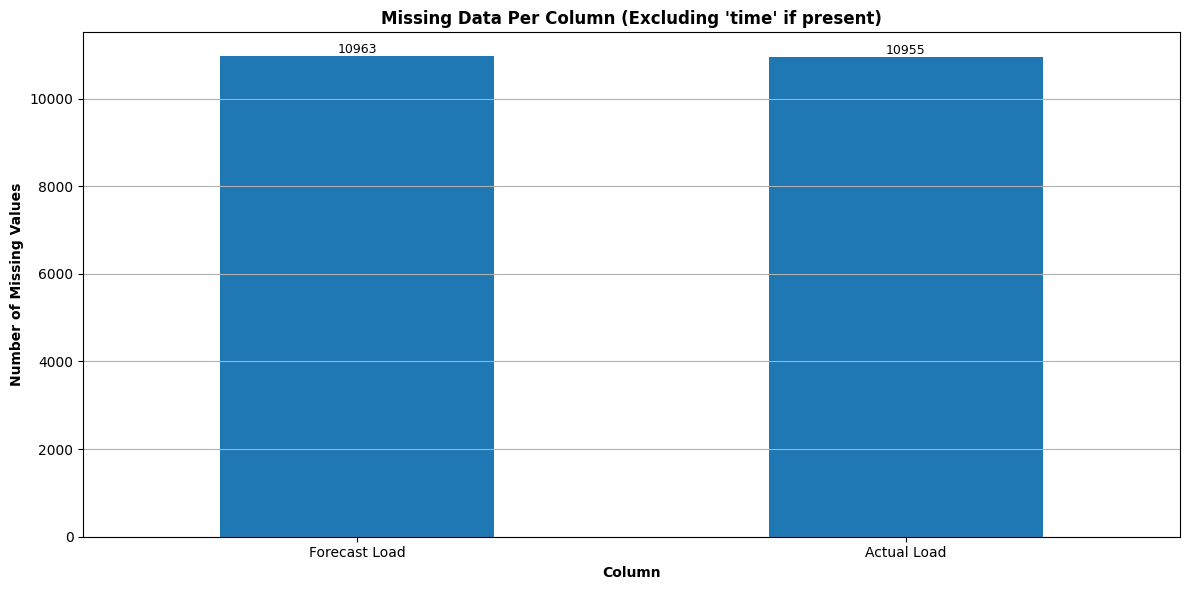

Missing Values Count (Raw Data):
 Time              7296
Forecast Load    10963
Actual Load      10955
dtype: int64

Missing Values Percentage (Raw Data):
 Time              7.398019
Forecast Load    11.116294
Actual Load      11.108182
dtype: float64
Time range in data: 2015-01-01 00:00:00 to 2024-12-31 23:00:00


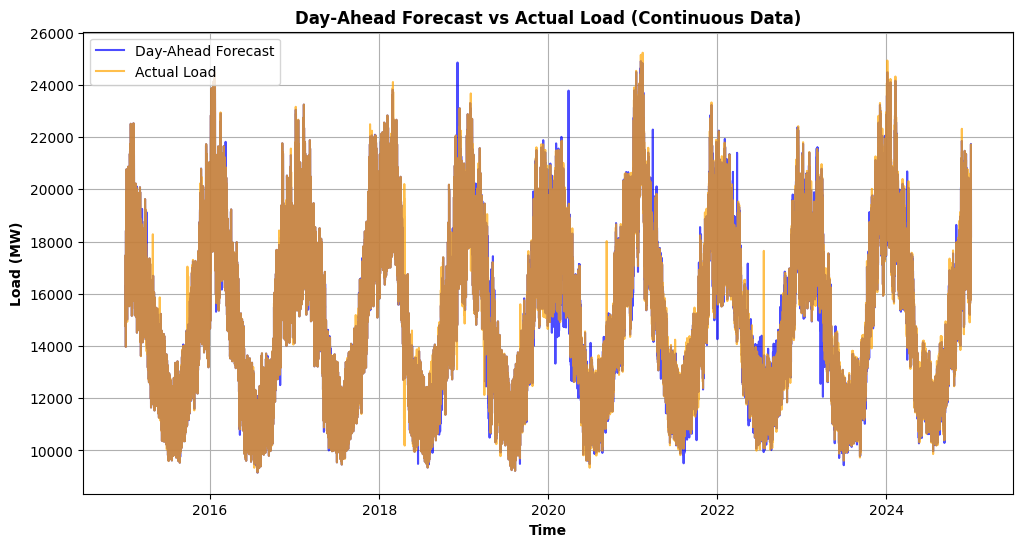

'\nimport pandas as pd\nimport os\nimport matplotlib.pyplot as plt\n\n# Example for file path\ndata_folder = "Data"\nexcel_files = sorted([f for f in os.listdir(data_folder) if f.endswith(\'.xlsx\')])  # Sort files chronologically\n\nall_data = pd.DataFrame()\n\n# Manually define the initial start date\ncurrent_datetime = pd.Timestamp("2014-01-01 00:00:00")  # Adjust based on the first file\n\nfor file in excel_files:\n    file_path = os.path.join(data_folder, file)\n    # Read Excel file\n    data = pd.read_excel(file_path, skiprows=7)  # Skip metadata rows\n\n    # Rename columns\n    data.columns = [\'Time\', \'Forecast Load\', \'Actual Load\']\n\n    # Use a counter to process 24 rows and skip the next 3 rows, with reset logic\n    filtered_data = pd.DataFrame()\n    count = 0  # Counter for rows\n    skip = 1  # Tracks rows to be skipped\n\n    for index, row in data.iterrows():\n        # If we are in the skipping phase, decrement the skip counter and continue\n        if skip > 

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns

# Define file paths
data_folder = "Data"
excel_files = sorted([f for f in os.listdir(data_folder) if f.endswith('.xlsx')])  # Sort files chronologically

raw_data_list = [] # To store raw data for vis..
all_data = pd.DataFrame() # This will store the cleaned data.

for file in excel_files:
    file_path = os.path.join(data_folder, file)

    # Extract year from filename (filename is just "2014.xlsx", "2015.xlsx", etc.)
    file_year = os.path.splitext(file)[0]  # Removes .xlsx and takes only the year

    # Read Excel file, skipping 6 rows
    data = pd.read_excel(file_path, skiprows=6, dtype=str)

        #Cleaning process
    # Rename first row as actual column names
    data.columns = ['Time', 'Forecast Load', 'Actual Load']

    # Store a copy of the raw data after column rename (before further cleaning)
    raw_data_list.append(data.copy())


    #Cleaning process
    # Rename first row as actual column names
    data.columns = ['Time', 'Forecast Load', 'Actual Load']
    
    # Rename second row with year-specific timestamp
    data.iloc[0] = [f'01.01.{file_year}', '', '']

    # Drop fully empty rows
    data = data.dropna(how='all')

    # Identify rows with date markers (xx.xx.xxxx format)
    date_mask = data['Time'].str.match(r'\d{2}\.\d{2}\.\d{4}', na=False)
    data['Is_Date'] = date_mask
    
    # Fill forward the date values
    data['Date'] = data.loc[data['Is_Date'], 'Time']
    data['Date'] = data['Date'].ffill()
    
    # Remove the rows that contain only the date markers
    data = data[~data['Is_Date']]
    
    # Convert "Time" format from "HH:MM - HH:MM" to just "HH:MM"
    data['Time'] = data['Time'].str.split(' - ').str[0]
    
    # Combine Date and Time to create full timestamp
    data['Timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d.%m.%Y %H:%M', errors='coerce')
    
    # Convert Forecast and Actual Load to numeric, handling errors
    data['Forecast Load'] = pd.to_numeric(data['Forecast Load'], errors='coerce')
    data['Actual Load'] = pd.to_numeric(data['Actual Load'], errors='coerce')

    # Append cleaned data
    all_data = pd.concat([all_data, data[['Timestamp', 'Forecast Load', 'Actual Load']]], ignore_index=True)

# Combine all raw data for visualization
raw_data = pd.concat(raw_data_list, ignore_index=True)

# Exclude any columns that start with 'Unnamed'
# Strip any whitespace around column names
raw_data.columns = raw_data.columns.str.strip()
# Drop columns containing 'Unnamed' in the name
raw_data = raw_data.loc[:, ~raw_data.columns.str.contains('^Unnamed', case=False)]

# Visualize missing values in raw data (before cleaning), row by row
# Prepare raw data for visualization (before cleaning)

# Reset index for clarity
raw_data_reset = raw_data.reset_index(drop=True)

# Select only relevant columns
raw_data_vis = raw_data_reset[['Forecast Load', 'Actual Load']].copy()

# Convert to NaN where applicable (just in case some empty strings remain)
raw_data_vis.replace('', np.nan, inplace=True)

# Drop 'time' column only if it exists
columns = raw_data_vis.columns.drop('time', errors='ignore')

# Calculate number of missing values per column (excluding 'time' if present)
missing_per_column = raw_data_vis[columns].isnull().sum()

# Plot
plt.figure(figsize=(12, 6))
ax = missing_per_column.plot(kind='bar', stacked=False)
plt.title("Missing Data Per Column (Excluding 'time' if present)", fontweight = 'bold')
plt.ylabel("Number of Missing Values", fontweight = 'bold')
plt.xlabel("Column", fontweight = 'bold')
plt.grid(axis='y')
plt.xticks(rotation=360)
plt.tight_layout()

# Add exact numbers on top of each bar
for i, value in enumerate(missing_per_column):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)
plt.savefig("ReportFigures/raw_empty_row.pdf", dpi=300, format="pdf")
plt.show()



#Print missing values counts and percentages for raw data
missing_counts = raw_data.isnull().sum()
missing_percent = raw_data.isnull().mean()*100
print("Missing Values Count (Raw Data):\n", missing_counts)
print("\nMissing Values Percentage (Raw Data):\n", missing_percent)

# After: Visualise Cleaned Data

# Verify the range of the data
print("Time range in data:", all_data['Timestamp'].min(), "to", all_data['Timestamp'].max())

# Plot the data, ensuring no missing hours
plt.figure(figsize=(12, 6))
plt.plot(all_data['Timestamp'], all_data['Forecast Load'], label='Day-Ahead Forecast', alpha=0.7, color='blue')
plt.plot(all_data['Timestamp'], all_data['Actual Load'], label='Actual Load', alpha=0.7, color='orange')
plt.xlabel('Time', fontweight = 'bold')
plt.ylabel('Load (MW)', fontweight = 'bold')
plt.title('Day-Ahead Forecast vs Actual Load (Continuous Data)', fontweight = 'bold')
plt.savefig("ReportFigures/time_series.pdf", dpi=300, format="pdf")
plt.legend()
plt.grid()
plt.show()

'''
# --- **INSERT CODE FOR HANDLING MISSING LAST TWO MONTHS HERE** ---
last_year_data = all_data['Timestamp'].dt.year.max() # Identify the last year in your data
missing_months = [10, 11, 12] # November and December

# 1. Identify timestamps for the missing last two months of the last year
start_missing_date = pd.to_datetime(f'2024-10-31 11:00:00')
end_missing_date = pd.to_datetime(f'{last_year_data}-12-31 23:00:00')
missing_timestamps = pd.date_range(start=start_missing_date, end=end_missing_date, freq='H') # Hourly timestamps

# 2. Filter historical data (excluding the last year) and for Nov/Dec
historical_data = all_data[all_data['Timestamp'].dt.year < 2024]
historical_nov_dec = historical_data[historical_data['Timestamp'].dt.month.isin(missing_months)]

# 3. Calculate average hourly load for Nov/Dec across historical years
average_hourly_load = historical_nov_dec.groupby(historical_nov_dec['Timestamp'].dt.hour).agg(
    {'Forecast Load': 'mean', 'Actual Load': 'mean'}
).rename(columns={'Forecast Load': 'Avg Forecast Load', 'Actual Load': 'Avg Actual Load'})

# 4. Create a DataFrame for the missing months with imputed values
imputed_data_list = []
for ts in missing_timestamps:
    hour = ts.hour
    if hour in average_hourly_load.index: # Make sure hour exists in average data (should always be true for hourly data)
        imputed_data_list.append({
            'Timestamp': ts,
            'Forecast Load': average_hourly_load.loc[hour, 'Avg Forecast Load'],
            'Actual Load': average_hourly_load.loc[hour, 'Avg Actual Load']
        })

imputed_data_df = pd.DataFrame(imputed_data_list)

# 5. Concatenate imputed data with the original all_data
all_data = pd.concat([all_data, imputed_data_df], ignore_index=True)

# Sort by timestamp to maintain chronological order
all_data = all_data.sort_values(by='Timestamp').reset_index(drop=True)

# Verify the range of the data *after* imputation
print("Time range in data after imputation:", all_data['Timestamp'].min(), "to", all_data['Timestamp'].max())


# Plot the data, ensuring no missing hours
plt.figure(figsize=(12, 6))
plt.plot(all_data['Timestamp'], all_data['Forecast Load'], label='Day-Ahead Forecast', alpha=0.7, color='blue')
plt.plot(all_data['Timestamp'], all_data['Actual Load'], label='Actual Load', alpha=0.7, color='orange')
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.title('Day-Ahead Forecast vs Actual Load (Continuous Data)')
plt.legend()
plt.grid()
plt.show()
'
'''


# Old Code
"""
import pandas as pd
import os
import matplotlib.pyplot as plt

# Example for file path
data_folder = "Data"
excel_files = sorted([f for f in os.listdir(data_folder) if f.endswith('.xlsx')])  # Sort files chronologically

all_data = pd.DataFrame()

# Manually define the initial start date
current_datetime = pd.Timestamp("2014-01-01 00:00:00")  # Adjust based on the first file

for file in excel_files:
    file_path = os.path.join(data_folder, file)
    # Read Excel file
    data = pd.read_excel(file_path, skiprows=7)  # Skip metadata rows

    # Rename columns
    data.columns = ['Time', 'Forecast Load', 'Actual Load']

    # Use a counter to process 24 rows and skip the next 3 rows, with reset logic
    filtered_data = pd.DataFrame()
    count = 0  # Counter for rows
    skip = 1  # Tracks rows to be skipped

    for index, row in data.iterrows():
        # If we are in the skipping phase, decrement the skip counter and continue
        if skip > 0:
            skip -= 1
            continue

        # Include the current row in the filtered_data
        filtered_data = pd.concat([filtered_data, pd.DataFrame([row])])
        count += 1

        # Once 24 rows are processed, skip the next 3 rows and reset the counter
        if count == 24:
            skip = 3  # Set skip counter for the next 3 rows
            count = 0  # Reset the counter

    # Generate timestamps dynamically based on the current_datetime
    num_rows = len(filtered_data)
    time_range = pd.date_range(start=current_datetime, periods=num_rows, freq='h')
    filtered_data['Time'] = time_range

    # Update current_datetime to continue from the end of this file's data
    current_datetime = time_range[-1] + pd.Timedelta(hours=1)

    # Convert columns to numeric, preserving NaN values
    filtered_data['Forecast Load'] = pd.to_numeric(filtered_data['Forecast Load'], errors='coerce')
    filtered_data['Actual Load'] = pd.to_numeric(filtered_data['Actual Load'], errors='coerce')

    # Append to the combined DataFrame
    all_data = pd.concat([all_data, filtered_data[['Time', 'Forecast Load', 'Actual Load']]], ignore_index=True)

# Verify the range of the data
print("Time range in data:", all_data['Time'].min(), "to", all_data['Time'].max())

# Plot the data, including null values
plt.figure(figsize=(12, 6))
plt.plot(all_data['Time'], all_data['Forecast Load'], label='Day-Ahead Forecast', alpha=0.7, color='blue')
plt.plot(all_data['Time'], all_data['Actual Load'], label='Actual Load', alpha=0.7, color='orange')
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.title('Day-Ahead Forecast vs Actual Load (With Skipped Rows)')
plt.legend()
plt.grid()
plt.show()
"""


### Distribution and Nature of Missing Values (Raw Excel Data)

When inspecting the raw Excel data files **before** applying any cleaning pipeline, we observe a significant number of missing values:

- **Forecast Load:** 10,963 missing values  
- **Actual Load:** 10,955 missing values  
- This accounts for approximately **11.1%** of all entries in each column.

Given that each year contains ~8,760 hourly data points, this corresponds to over **1.25 years of missing hourly records** — which highlights the importance of robust preprocessing.

---

### Are the Missing Values Clustered in Time?

While the total number exceeds **8,700 entries**, these missing values are **not clustered into a single year or season**.

Through year-wise inspection, we observed:

- A **small number of missing entries nearly every year**, primarily due to:
  - **Daylight Saving Time transitions** (e.g. 02:00 AM on the last Sunday of March, which does not exist),
- A **full day of missing forecasts** on **2015-11-26** (all 24 hours absent),
- A **block of missing actual load values** on **2016-07-19** from 08:00 to 23:00.

Outside of these small clusters, most missing values are **scattered across the dataset**. This distribution indicates that:

- No **single year dominates** the missing entries,
- The majority of missingness arises from **many small-scale gaps**, **a few isolated outages**, and **calendar anomalies** like DST.

---

### Key Takeaways

- The raw data contains **over a year's worth of missing values**, but these are mostly **spread across time**, not isolated to one period.
- Our final cleaned dataset addresses many of these issues via interpolation and so on.
- This insight supports the need for both **exploratory data analysis** and a **carefully designed preprocessing pipeline**.

## Data Visualization

### Plots Created:
1. Forecast vs Actual Load (Time Series)
2. Yearly Trend Analysis
3. Forecast Error Over Time
4. Missing Data Heatmap


In [3]:
print(data.head())       # Check first few rows
print(data.describe())   # Statistical summary
print(data.isnull().sum())  # Missing values


    Time  Forecast Load  Actual Load  Is_Date        Date           Timestamp
1  00:00        17872.0      18350.0    False  01.01.2024 2024-01-01 00:00:00
2  01:00        18118.0      18364.0    False  01.01.2024 2024-01-01 01:00:00
3  02:00        17993.0      18224.0    False  01.01.2024 2024-01-01 02:00:00
4  03:00        17851.0      18030.0    False  01.01.2024 2024-01-01 03:00:00
5  04:00        17827.0      18009.0    False  01.01.2024 2024-01-01 04:00:00
       Forecast Load   Actual Load                      Timestamp
count    8784.000000   8784.000000                           8785
mean    15554.240779  15577.568420  2024-07-01 23:49:11.713147648
min      9965.000000   9862.000000            2024-01-01 00:00:00
25%     12759.750000  12841.750000            2024-04-01 12:00:00
50%     15250.000000  15228.500000            2024-07-02 00:00:00
75%     17989.500000  17962.000000            2024-10-01 12:00:00
max     24480.000000  24930.000000            2024-12-31 23:00:00
std 

### Analyse Data Each Year

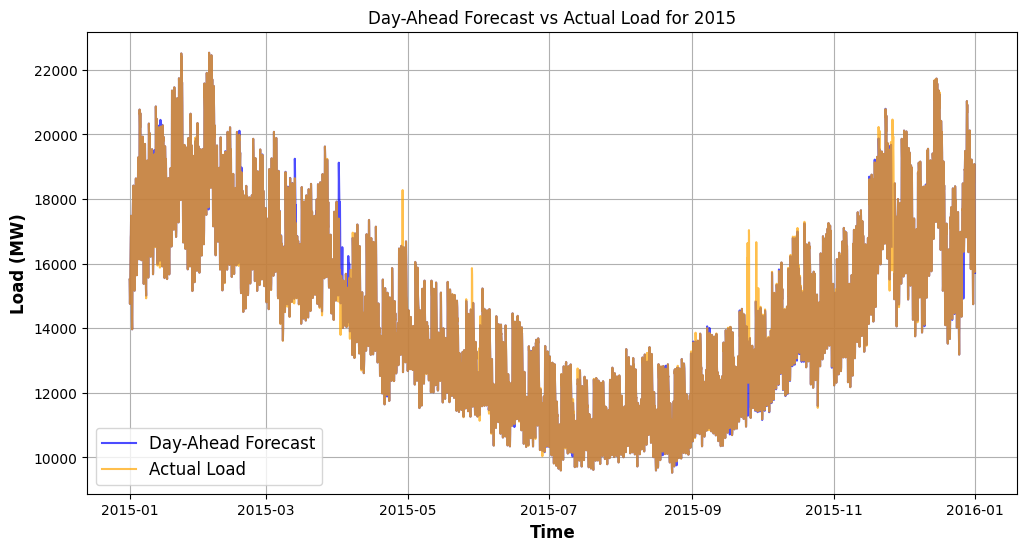

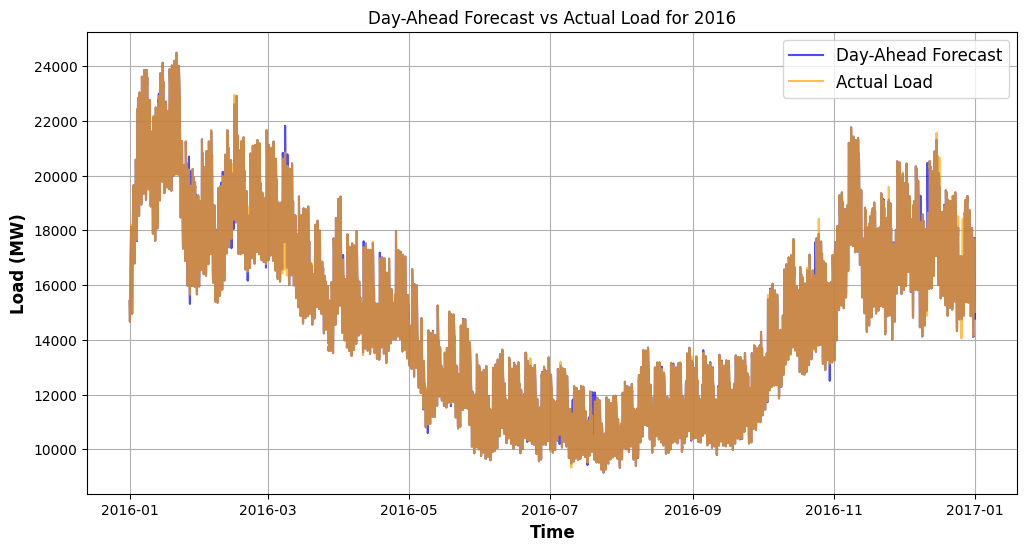

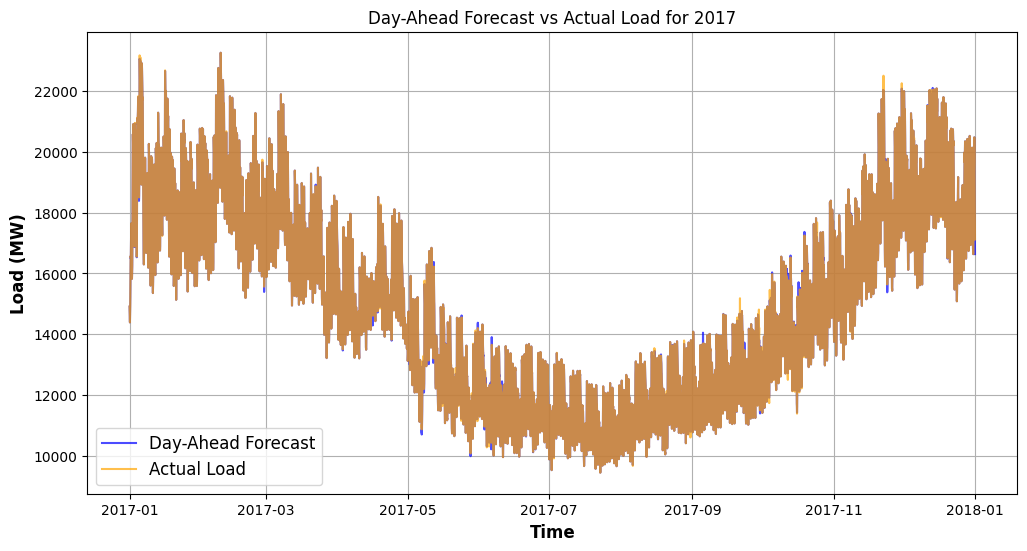

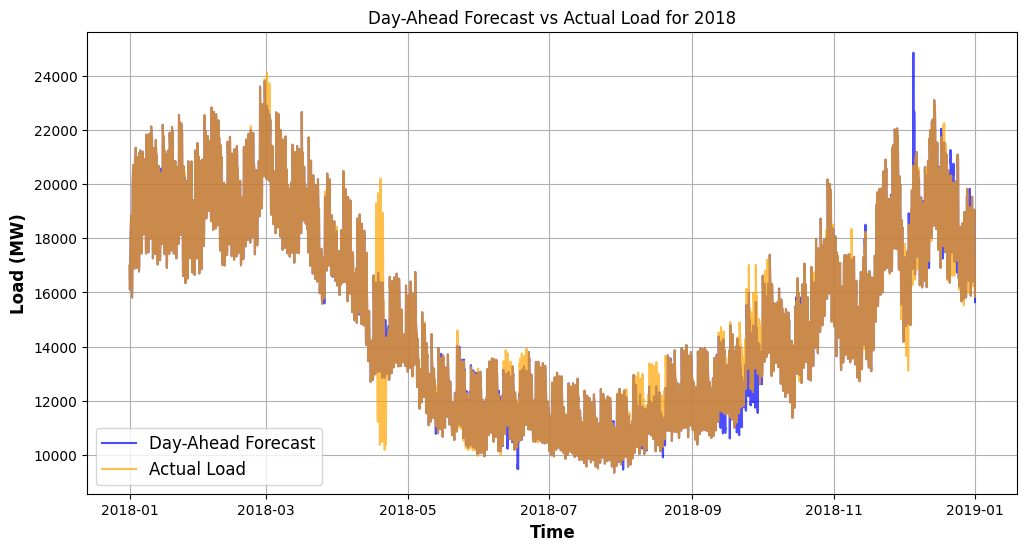

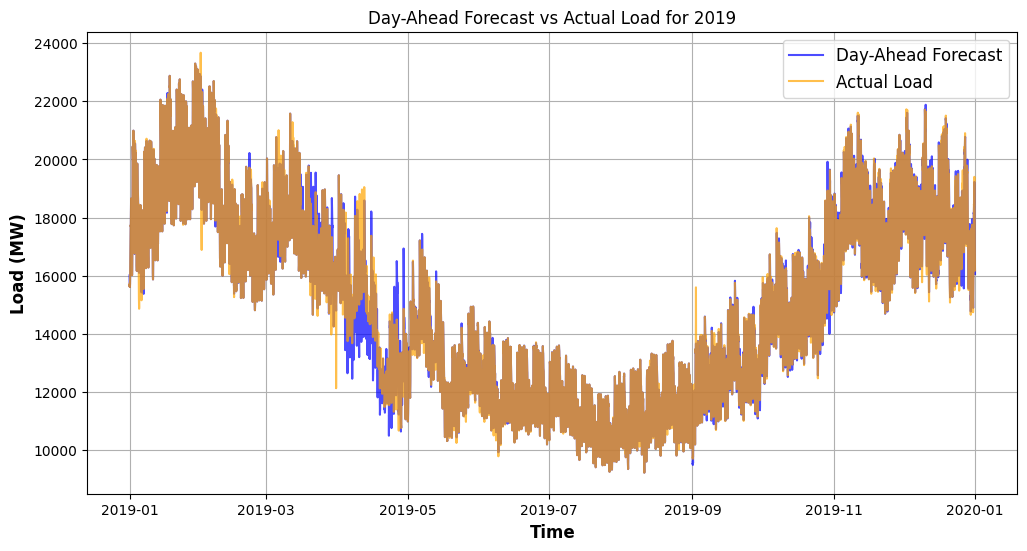

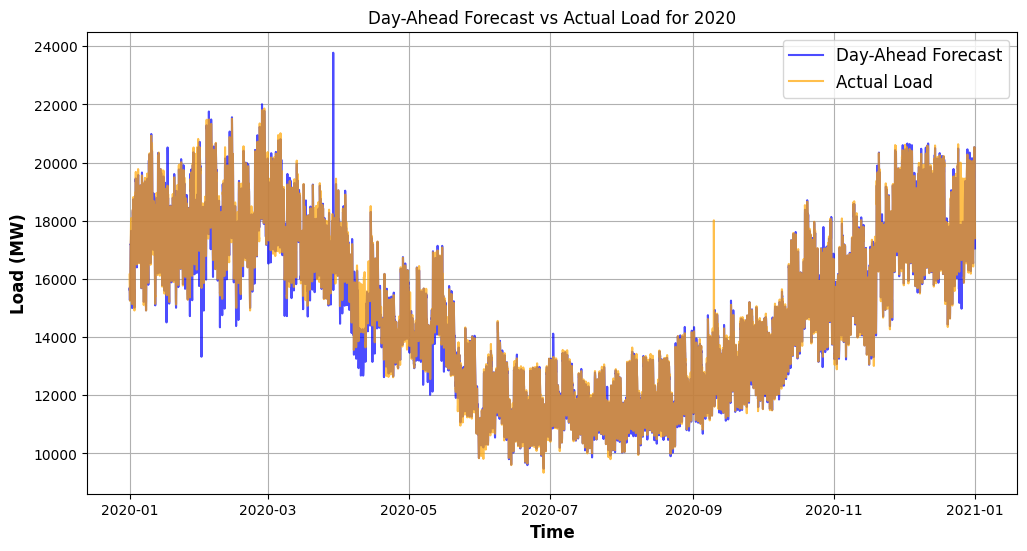

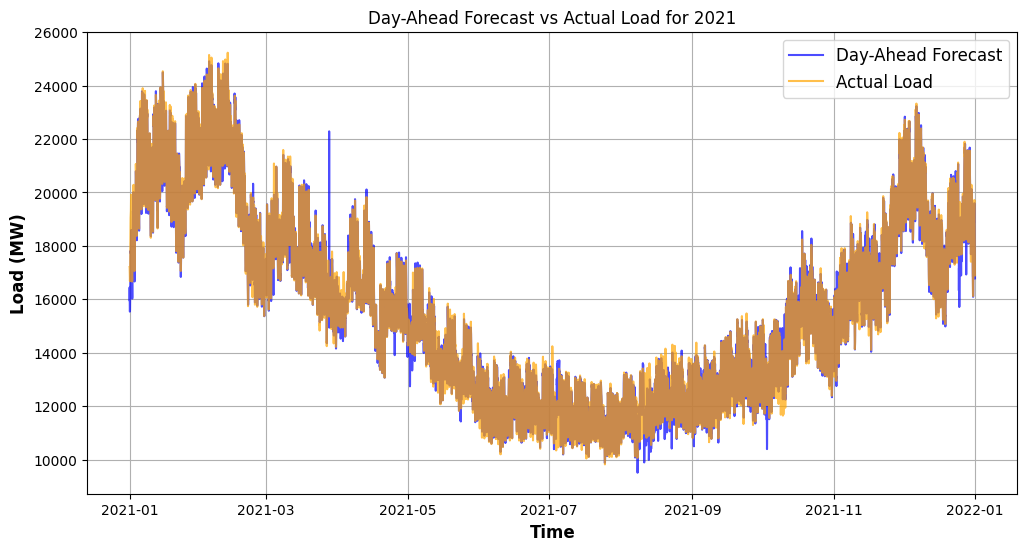

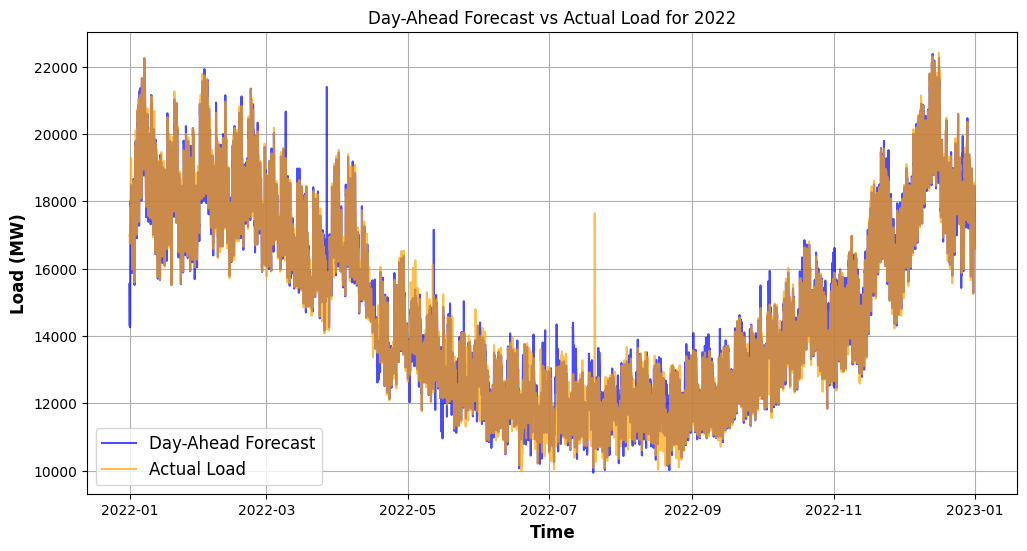

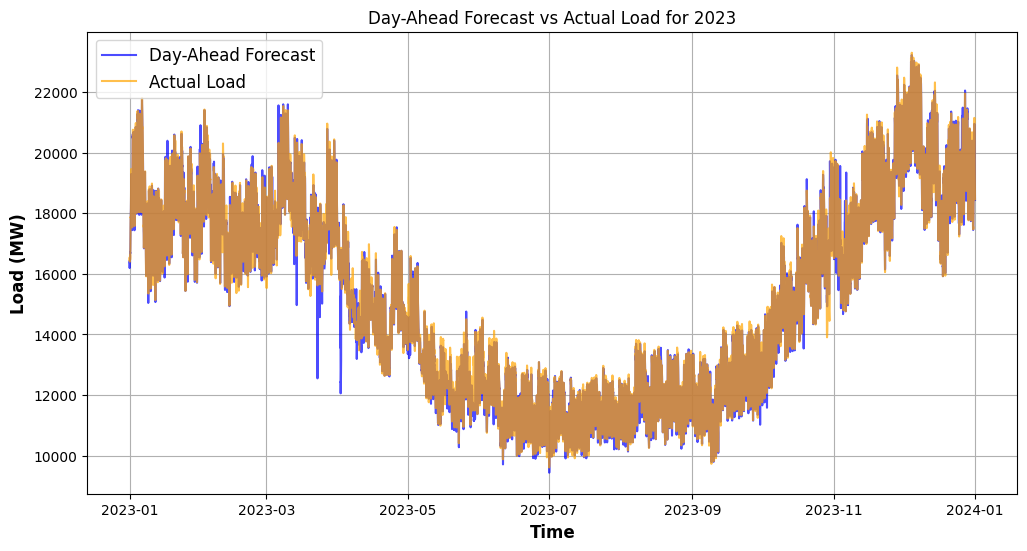

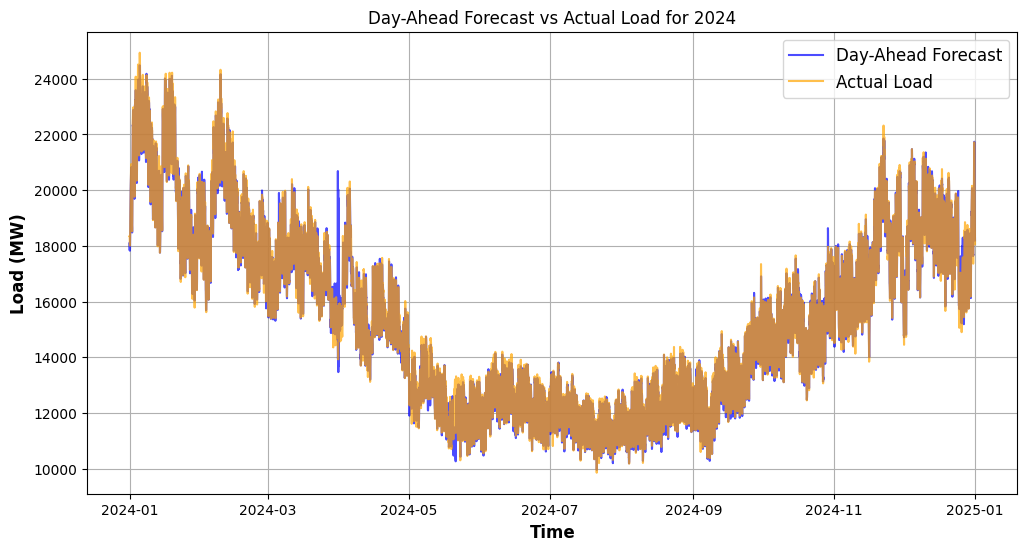

In [ ]:
import os
import matplotlib.pyplot as plt

# Ensure the ReportFigures directory exists
os.makedirs("ReportFigures", exist_ok=True)

# Group data by year
for year, year_data in all_data.groupby(all_data['Timestamp'].dt.year):
    plt.figure(figsize=(12, 6))
    plt.plot(year_data['Timestamp'], year_data['Forecast Load'], label='Day-Ahead Forecast', alpha=0.7, color='blue')
    plt.plot(year_data['Timestamp'], year_data['Actual Load'], label='Actual Load', alpha=0.7, color='orange')
    
    plt.xlabel('Time', fontsize=12, fontweight='bold')
    plt.ylabel('Load (MW)', fontsize=12, fontweight='bold')
    plt.title(f'Day-Ahead Forecast vs Actual Load for {year}', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid()
    
    # Save to PDF
    output_path = f"ReportFigures/LoadForecast_{year}.pdf"
    plt.savefig(output_path, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()


## Exploratory Data Analysis (EDA)

### What we analyzed:
- Summary statistics
- Missing values
- Time range verification

### Summary Statistics

In [5]:
# Ensure 'Timestamp' is in datetime format
all_data['Year'] = all_data['Timestamp'].dt.year  # Extract the year

# Group by year and calculate statistics
summary_stats = all_data.groupby('Year').agg({
    'Forecast Load': ['mean', 'max', 'min'],
    'Actual Load': ['mean', 'max', 'min']
})

# Print summary statistics
print(summary_stats)




     Forecast Load                    Actual Load                 
              mean      max     min          mean      max     min
Year                                                              
2015  14679.735119  22531.0  9527.0  14689.310388  22530.0  9527.0
2016  15073.934882  24485.0  9147.0  15070.784101  24485.0  9157.0
2017  15170.839155  23246.0  9458.0  15169.687215  23246.0  9457.0
2018  15400.935388  24854.0  9342.0  15467.212557  24108.0  9343.0
2019  15224.333447  23300.0  9217.0  15236.381963  23672.0  9217.0
2020  15100.248634  23779.0  9476.0  15125.462090  21861.0  9338.0
2021  15831.555708  24911.0  9508.0  15857.231735  25230.0  9820.0
2022  15015.697146  22379.0  9938.0  15023.900457  22416.0  9992.0
2023  15312.009932  23229.0  9435.0  15352.816210  23305.0  9608.0
2024  15554.240779  24480.0  9965.0  15577.568420  24930.0  9862.0


### Comment Summary stats
When we analyze this, we see that the minimum daily energy consumption in 2014 was 14,295.0. However, when we look at the following years—2015 and onwards—the minimum values are generally around 9,500. The reason for this difference is that, for 2014, only data from December is available. In other words, there is no comparison between summer and winter months for that year.



### Saving Processed Data

In [6]:
all_data.to_csv('combined_data.csv', index=False)


### Missing Data HeatMap

<Figure size 1200x600 with 0 Axes>

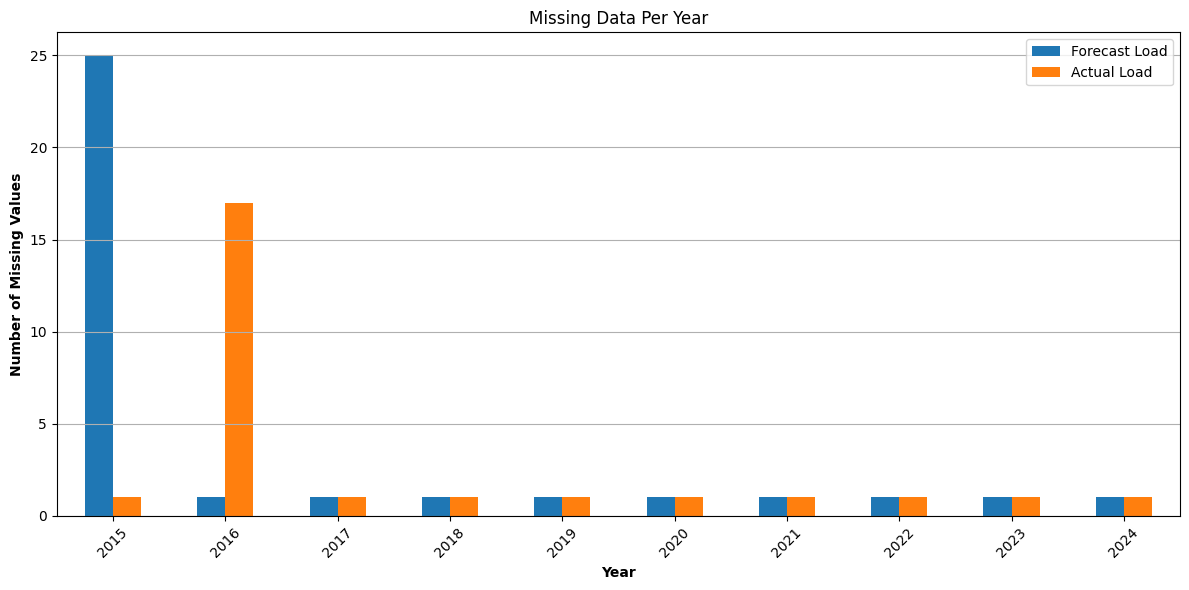

=== Missing Values by Year ===
       Timestamp  Forecast Load  Actual Load  Year
2015           0             25            1     0
2016           0              1           17     0
2017           0              1            1     0
2018           0              1            1     0
2019           0              1            1     0
2020           0              1            1     0
2021           0              1            1     0
2022           0              1            1     0
2023           0              1            1     0
2024           0              1            1     0
Total          0             34           26     0

=== Detailed Missing Values with Timestamps ===
        Year           Timestamp         Column
2090    2015 2015-03-29 02:00:00  Forecast Load
7897    2015 2015-11-26 00:00:00  Forecast Load
7898    2015 2015-11-26 01:00:00  Forecast Load
7899    2015 2015-11-26 02:00:00  Forecast Load
7900    2015 2015-11-26 03:00:00  Forecast Load
7901    2015 2015-11

In [7]:
import matplotlib.pyplot as plt

# Group by year and count missing values
missing_by_year = all_data.groupby(all_data['Timestamp'].dt.year)[['Forecast Load', 'Actual Load']].apply(lambda x: x.isnull().sum())

# Drop NaN years (if Timestamp was NaT)
missing_by_year = missing_by_year.dropna()

# Plot
plt.figure(figsize=(12, 6))
missing_by_year.plot(kind='bar', stacked=False, figsize=(12, 6))

plt.title("Missing Data Per Year")
plt.ylabel("Number of Missing Values", fontweight='bold')
plt.xlabel("Year", fontweight='bold')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("ReportFigures/missing_value_chart.pdf", dpi=300, format="pdf")
plt.show()


# Step 1: Missing count per year
missing_by_year = all_data.groupby(all_data['Timestamp'].dt.year).apply(lambda x: x.isnull().sum())

# Step 2: Add total row
total_missing = all_data.isnull().sum()
total_missing.name = 'Total'
missing_by_year = pd.concat([missing_by_year, total_missing.to_frame().T])

# Step 3: Display missing counts
print("=== Missing Values by Year ===")
print(missing_by_year)

# Step 4: Show detailed list of each missing value
print("\n=== Detailed Missing Values with Timestamps ===")

# Melt the DataFrame to long format
melted = all_data[['Timestamp', 'Forecast Load', 'Actual Load']].melt(id_vars='Timestamp',
                                                                      var_name='Column',
                                                                      value_name='Value')
# Filter missing values
missing_details = melted[melted['Value'].isnull()].copy()

# Extract Year from Timestamp
missing_details['Year'] = missing_details['Timestamp'].dt.year

# Display or save
print(missing_details[['Year', 'Timestamp', 'Column']])


### Results: Missing Data Analysis

#### 1. Daylight Saving Time Transitions (Spring Forward)

Most of the missing values consistently occur on the **last Sunday of March at exactly 02:00 AM** for each year from **2015 to 2024**.  
This is a well-known artifact caused by the **start of Daylight Saving Time (DST)** in Norway and many other European countries.

During this transition, clocks are set forward from **01:59 AM to 03:00 AM**, effectively skipping the **02:00–02:59 AM** interval.  
As a result, data points for `02:00 AM` on these days do **not exist** — these are not true "missing" values but reflect a **non-existent hour** in local time.

🔍 This explains the repeated gaps at:
- `2015-03-29 02:00:00`
- `2016-03-27 02:00:00`
- `2017-03-26 02:00:00`
- ...
- `2024-03-31 02:00:00`

---

#### 2. Isolated System or Forecast Gaps

Aside from DST-related artifacts, the dataset also includes some **irregular or technical data gaps**:

- **Full-day forecast gap on `2015-11-26`**: All 24 hourly values for the `Forecast Load` are missing.  
  This may be due to a data ingestion error or a system pause, possibly related to holidays.

- **Partial missing values for `Actual Load` on `2016-07-19`**, specifically between `08:00` and `23:00`.  
  This pattern suggests potential **data logging issues** or **sensor/network failures**.

---

### Analyses

The **majority of missing entries** are expected and result from **DST transitions**, which can often be safely ignored or interpolated over.

However, **irregular missing values** (such as entire-day outages or partial gaps) require **special attention**:
- Remove them from training/testing if they are too sparse to reliably fill.
- Use surrounding values or model-based imputation if continuity is critical for downstream forecasting models.


### Handle Missing Data & HeatMap

<Figure size 1200x600 with 0 Axes>

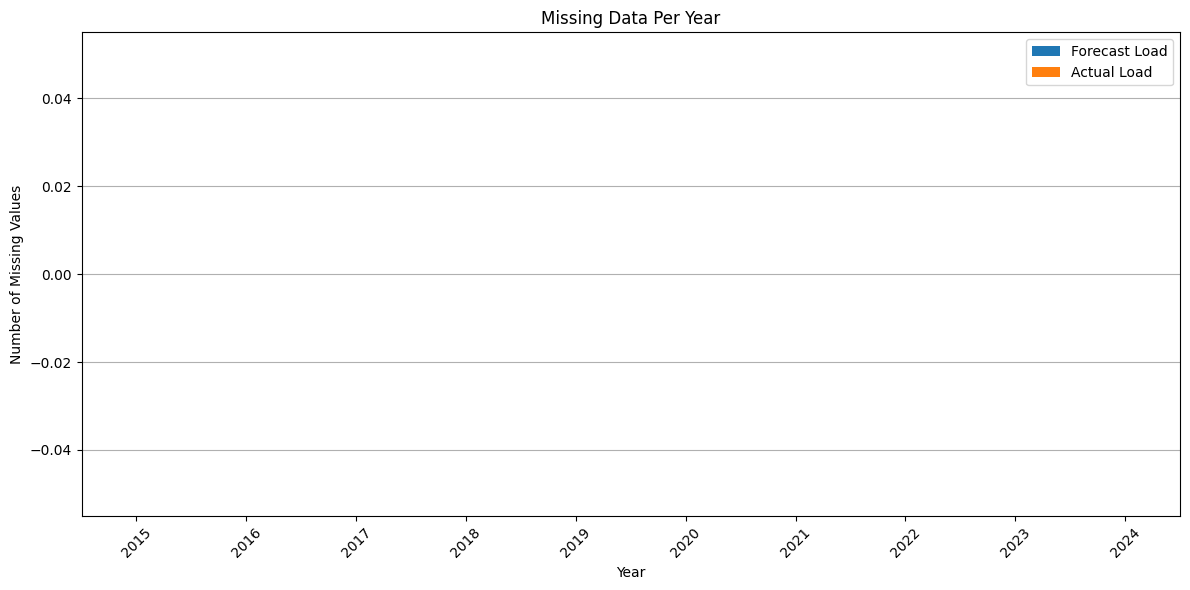

=== Missing Values by Year ===
       Forecast Load  Actual Load  Timestamp  Year
2015               0            0        NaN   NaN
2016               0            0        NaN   NaN
2017               0            0        NaN   NaN
2018               0            0        NaN   NaN
2019               0            0        NaN   NaN
2020               0            0        NaN   NaN
2021               0            0        NaN   NaN
2022               0            0        NaN   NaN
2023               0            0        NaN   NaN
2024               0            0        NaN   NaN
Total              0            0        0.0   0.0

=== Detailed Missing Values with Timestamps ===
Empty DataFrame
Columns: [Year, Timestamp, Column]
Index: []


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def smart_fill_hourly_by_pattern(data, max_gap_hours=6):
    """
    Interpolates short gaps using cubic.
    Fills longer gaps hour-by-hour using average of same hour/weekday from previous weeks.
    """
    from datetime import timedelta

    df = data.copy()
    df = df.sort_values('Timestamp').reset_index(drop=True)

    # Add helper columns
    df['Weekday'] = df['Timestamp'].dt.weekday  # Monday=0
    df['Hour'] = df['Timestamp'].dt.hour

    # Step 1: Interpolate short gaps with cubic
    for col in ['Forecast Load', 'Actual Load']:
        df[col] = df[col].interpolate(method='cubic', limit_area='inside', limit_direction='both')

    # Step 2: Fill longer gaps hour-by-hour from past weekly patterns
    for col in ['Forecast Load', 'Actual Load']:
        missing_mask = df[col].isna()

        for idx in df[missing_mask].index:
            ts = df.loc[idx, 'Timestamp']
            weekday = df.loc[idx, 'Weekday']
            hour = df.loc[idx, 'Hour']

            # Look back up to 8 weeks, same weekday & hour
            past_window = ts - pd.to_timedelta(np.arange(7, 8 * 7 + 1, 7), unit='D')
            past_values = []

            for past_date in past_window:
                candidate_time = past_date.replace(hour=hour, minute=0)
                match = df[df['Timestamp'] == candidate_time]
                if not match.empty and pd.notna(match[col].values[0]):
                    past_values.append(match[col].values[0])

            # Fill with mean of past values
            if past_values:
                df.loc[idx, col] = np.mean(past_values)

    # Drop helper columns
    return df.drop(columns=['Weekday', 'Hour'])


# Ensure Timestamp is datetime and sorted
all_data['Timestamp'] = pd.to_datetime(all_data['Timestamp'])
all_data = all_data.sort_values('Timestamp').reset_index(drop=True)

# Apply the smart interpolation strategy
all_data = smart_fill_hourly_by_pattern(all_data)

# --- Missing Data Analysis ---
# Group by year and count missing values
missing_by_year = all_data.groupby(all_data['Timestamp'].dt.year)[['Forecast Load', 'Actual Load']].apply(lambda x: x.isnull().sum())
missing_by_year = missing_by_year.dropna()

# Plot missing data per year
plt.figure(figsize=(12, 6))
missing_by_year.plot(kind='bar', stacked=False, figsize=(12, 6))
plt.title("Missing Data Per Year")
plt.ylabel("Number of Missing Values")
plt.xlabel("Year")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Add total row
total_missing = all_data.isnull().sum()
total_missing.name = 'Total'
missing_by_year = pd.concat([missing_by_year, total_missing.to_frame().T])

# Display missing summary
print("=== Missing Values by Year ===")
print(missing_by_year)

# Show detailed list of each missing value
print("\n=== Detailed Missing Values with Timestamps ===")
melted = all_data[['Timestamp', 'Forecast Load', 'Actual Load']].melt(id_vars='Timestamp',
                                                                      var_name='Column',
                                                                      value_name='Value')
missing_details = melted[melted['Value'].isnull()].copy()
missing_details['Year'] = missing_details['Timestamp'].dt.year
print(missing_details[['Year', 'Timestamp', 'Column']])

### Dahiyane Plot

In [9]:
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display


# Define aggregation options
aggregation_options = {
    "Raw Data (Original)": "T",  # Minute-level
    "Hourly": "H",
    "Daily": "D",
    "Weekly": "W",
    "Monthly": "M",
    "Yearly": "Y"
}

# Create dropdown widget
aggregation_selector = widgets.Dropdown(
    options=aggregation_options,
    value="H",  # Default to hourly
    description="Aggregation Level:",
    style={'description_width': 'initial'}
)

# Function to plot interactive data
def plot_interactive_plotly(aggregation):
    # Resample data based on selected aggregation level
    resampled_data = all_data.set_index('Timestamp').resample(aggregation).mean().reset_index()

    # Create figure
    fig = go.Figure()

    # Add Forecast and Actual Load lines
    fig.add_trace(go.Scatter(
        x=resampled_data['Timestamp'], y=resampled_data['Forecast Load'],
        mode='lines', name='Day-Ahead Forecast', line=dict(color='blue')
    ))
    
    fig.add_trace(go.Scatter(
        x=resampled_data['Timestamp'], y=resampled_data['Actual Load'],
        mode='lines', name='Actual Load', line=dict(color='orange')
    ))

    # Highlight No-Wind Periods (if both values are NaN)
    no_wind_periods = resampled_data[(resampled_data['Forecast Load'].isna()) & (resampled_data['Actual Load'].isna())]

    fig.add_trace(go.Scatter(
        x=no_wind_periods['Timestamp'], y=[None] * len(no_wind_periods),
        mode='markers', name='No Wind Periods', marker=dict(color='red', symbol='x')
    ))

    # Update layout
    fig.update_layout(
        title=f'Day-Ahead Forecast vs Actual Load ({aggregation} Aggregation)',
        xaxis_title='Time',
        yaxis_title='Load (MW)',
        legend=dict(orientation="h"),
        template='plotly_white'
    )

    fig.show()

# Display interactive widget
display(widgets.interactive(plot_interactive_plotly, aggregation=aggregation_selector))


interactive(children=(Dropdown(description='Aggregation Level:', index=1, options={'Raw Data (Original)': 'T',…

### Anomalies

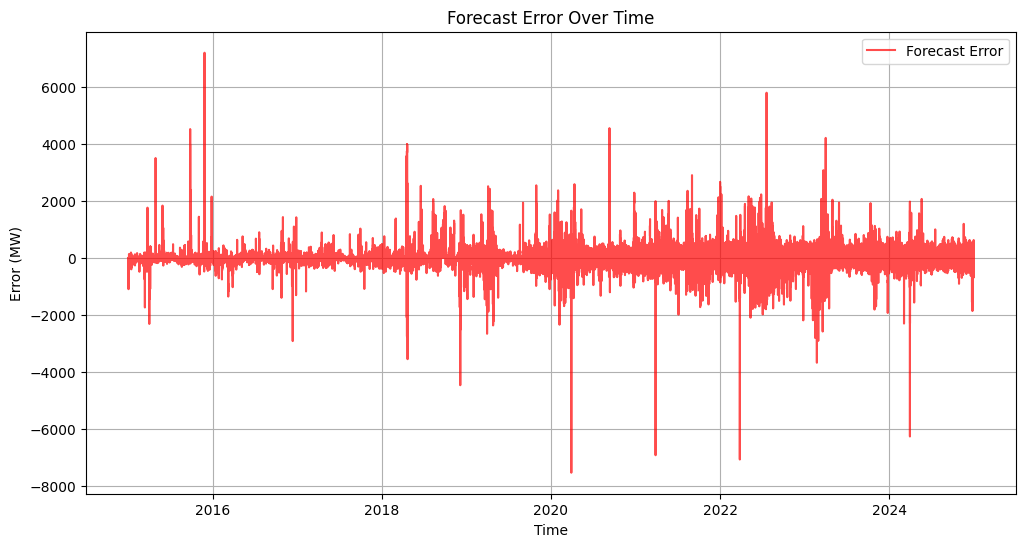

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(all_data['Timestamp'], all_data['Actual Load'] - all_data['Forecast Load'], 
         label='Forecast Error', alpha=0.7, color='red')

plt.xlabel('Time')
plt.ylabel('Error (MW)')
plt.title('Forecast Error Over Time')
plt.legend()
plt.grid()
plt.show()


### Monthly average with group by structure

In [11]:
# Ensure 'Timestamp' is in datetime format (if not already)
all_data['Timestamp'] = pd.to_datetime(all_data['Timestamp'], errors='coerce')

# Extract 'Year' and 'Month' from 'Timestamp'
all_data['Year'] = all_data['Timestamp'].dt.year
all_data['Month'] = all_data['Timestamp'].dt.month

# Group by 'Year' and 'Month' and calculate averages
monthly_avg = all_data.groupby(['Year', 'Month'], as_index=True)[['Forecast Load', 'Actual Load']].mean()

# Display the result
print(monthly_avg)



            Forecast Load   Actual Load
Year Month                             
2015 1       18279.598118  18265.288978
     2       18032.017857  18023.107143
     3       16557.501141  16516.821073
     4       14570.009722  14490.023611
     5       13318.690860  13331.307796
...                   ...           ...
2024 8       12381.735215  12449.002688
     9       13258.136111  13290.179167
     10      15245.664430  15258.950336
     11      17546.643056  17564.827778
     12      18502.290323  18469.852151

[120 rows x 2 columns]


## Next Steps

**Completed:**
 Data Cleaning
 Data Exploration
 Basic Visualization

**To Do Next:**
 Feature Engineering (Rolling Averages, Lag Features)
 Outlier Detection & Handling
 Correlation Analysis
 Seasonality & Trend Analysis
 Data Imbalance Check


## Feature Engineering

### Why is Feature Engineering Important?
To improve forecasting accuracy, we create new time-dependent features such as:
- **Lag Features:** Previous values (e.g., `t-1`, `t-24`) to capture trends.
- **Rolling Averages:** Smooth short-term fluctuations.

### Steps:
1. Compute lag features.
2. Calculate rolling averages.
3. Add day-of-week and month indicators.


               Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8640 2015-12-26 23:00:00        14920.0      17065.0  2015     12   26    23   
8641 2015-12-27 00:00:00        16696.0      16695.0  2015     12   27     0   
8642 2015-12-27 01:00:00        16494.0      16494.0  2015     12   27     1   
8643 2015-12-27 02:00:00        16412.0      16411.0  2015     12   27     2   
8644 2015-12-27 03:00:00        16369.0      16369.0  2015     12   27     3   

      Weekday  Is_Weekend  Lag_1H_Forecast  ...  Rolling_6H_Actual  \
8640        5           1          17328.0  ...       17795.666667   
8641        6           1          14920.0  ...       17522.166667   
8642        6           1          16696.0  ...       17235.500000   
8643        6           1          16494.0  ...       16952.333333   
8644        6           1          16412.0  ...       16726.833333   

      Rolling_24H_Forecast  Rolling_24H_Actual  Rolling_168H_Forecast  \
8640          16621.00000

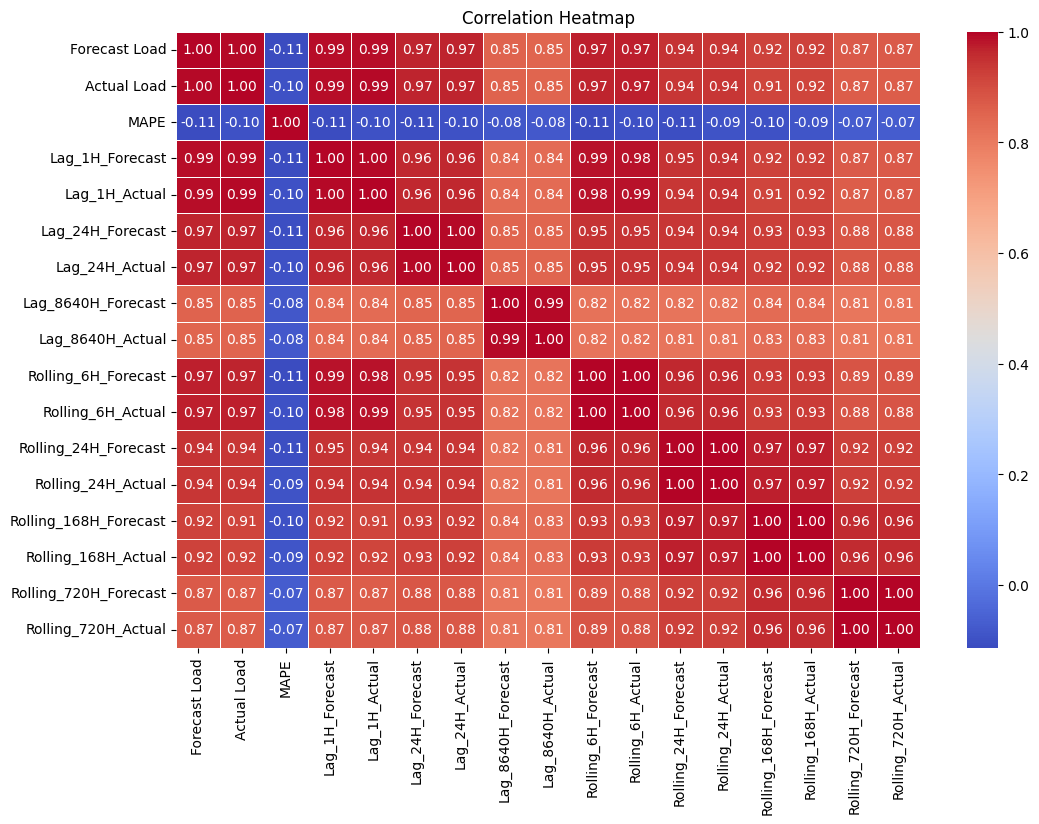

In [12]:
# Convert 'Timestamp' to datetime
all_data['Timestamp'] = pd.to_datetime(all_data['Timestamp'], errors='coerce')

# Extracting additional time-based features
all_data.loc[:, 'Year'] = all_data['Timestamp'].dt.year
all_data.loc[:, 'Month'] = all_data['Timestamp'].dt.month
all_data.loc[:, 'Day'] = all_data['Timestamp'].dt.day
all_data.loc[:, 'Hour'] = all_data['Timestamp'].dt.hour
all_data.loc[:, 'Weekday'] = all_data['Timestamp'].dt.weekday  # Monday=0, Sunday=6
all_data.loc[:, 'Is_Weekend'] = all_data['Weekday'].isin([5, 6]).astype(int)

# Creating lag features
    # One hour lag
all_data.loc[:, 'Lag_1H_Forecast'] = all_data['Forecast Load'].shift(1)
all_data.loc[:, 'Lag_1H_Actual'] = all_data['Actual Load'].shift(1)
    # One Day lag
all_data.loc[:, 'Lag_24H_Forecast'] = all_data['Forecast Load'].shift(24)
all_data.loc[:, 'Lag_24H_Actual'] = all_data['Actual Load'].shift(24)
    # One Year lag
all_data.loc[:, 'Lag_8640H_Forecast'] = all_data['Forecast Load'].shift(8640)
all_data.loc[:, 'Lag_8640H_Actual'] = all_data['Actual Load'].shift(8640)


# Rolling mean features
    # Six hour window
all_data.loc[:, 'Rolling_6H_Forecast'] = all_data['Forecast Load'].rolling(window=6, min_periods=1).mean()
all_data.loc[:, 'Rolling_6H_Actual'] = all_data['Actual Load'].rolling(window=6, min_periods=1).mean()
    # One day window
all_data.loc[:, 'Rolling_24H_Forecast'] = all_data['Forecast Load'].rolling(window=24, min_periods=1).mean()
all_data.loc[:, 'Rolling_24H_Actual'] = all_data['Actual Load'].rolling(window=24, min_periods=1).mean()
    # One week window
all_data.loc[:, 'Rolling_168H_Forecast'] = all_data['Forecast Load'].rolling(window=168, min_periods=1).mean()
all_data.loc[:, 'Rolling_168H_Actual'] = all_data['Actual Load'].rolling(window=168, min_periods=1).mean()
    # One month window
all_data.loc[:, 'Rolling_720H_Forecast'] = all_data['Forecast Load'].rolling(window=720, min_periods=1).mean()
all_data.loc[:, 'Rolling_720H_Actual'] = all_data['Actual Load'].rolling(window=720, min_periods=1).mean()

"""    # One year window
all_data.loc[:, 'Rolling_8640H_Forecast'] = all_data['Forecast Load'].rolling(window=8640, min_periods=1).mean()
all_data.loc[:, 'Rolling_8640H_Actual'] = all_data['Actual Load'].rolling(window=8640, min_periods=1).mean()
"""

# Difference between forecast and actual load
all_data.loc[:, 'Load_Error'] = all_data['Forecast Load'] - all_data['Actual Load']
all_data.loc[:, 'Absolute_Error'] = abs(all_data['Load_Error'])

# Percentage error (MAPE) with a safeguard for division by zero
all_data.loc[:, 'MAPE'] = (all_data['Absolute_Error'] / (all_data['Actual Load'] + 1e-6)) * 100

# Handling missing values that may arise due to lag features
all_data = all_data.dropna()

# Display processed data sample
print(all_data.head())


# Select relevant numerical columns only (excluding non-existent or highly NaN features)
columns_to_include = [
    'Forecast Load', 'Actual Load', 'MAPE', 
    'Lag_1H_Forecast', 'Lag_1H_Actual', 'Lag_24H_Forecast', 'Lag_24H_Actual', 'Lag_8640H_Forecast', 'Lag_8640H_Actual',
    'Rolling_6H_Forecast', 'Rolling_6H_Actual', 'Rolling_24H_Forecast', 'Rolling_24H_Actual', 
    'Rolling_168H_Forecast', 'Rolling_168H_Actual', 'Rolling_720H_Forecast', 'Rolling_720H_Actual'
]

# Ensure only existing columns are selected (avoiding errors)
columns_to_include = [col for col in columns_to_include if col in all_data.columns]

# Compute correlation matrix
corr_matrix = all_data[columns_to_include].corr()

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


## Outlier Detection

### Why is it Important?
Outliers can distort predictions and must be identified.

### Steps:
1. **Visualize using Box Plots**
2. **Compute Z-Scores or IQR**
3. **Decide: Remove or Transform?**


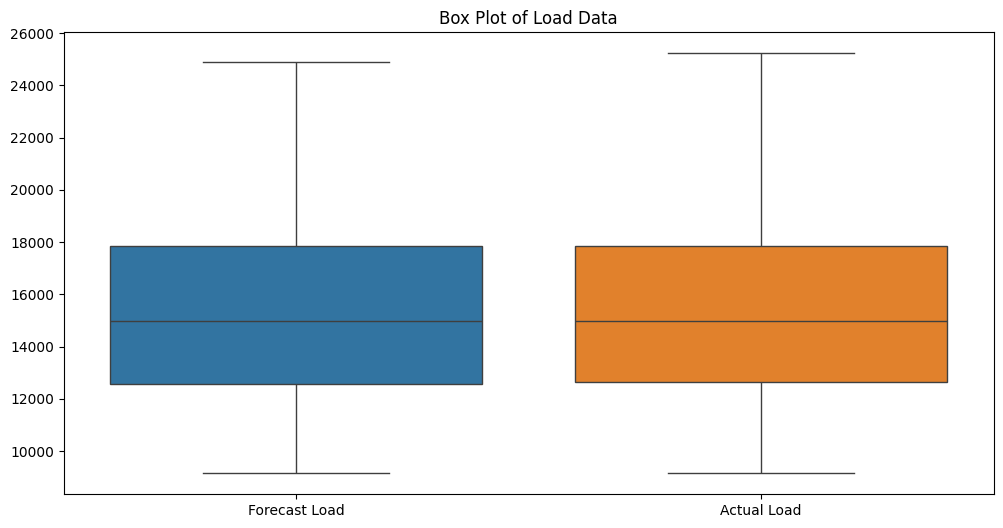

In [13]:
### *Outlier Detection Code Below:*

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=all_data[['Forecast Load', 'Actual Load']])
plt.title('Box Plot of Load Data')
plt.show()


## Correlation Analysis

### Why is it Important?
Identifying relationships between variables helps remove redundancy.

### Steps:
1. Compute correlation matrix.
2. Visualize with a heatmap.
3. Identify highly correlated features.


In [14]:
### *Correlation Analysis Code Below:*

from scipy.stats import zscore

all_data['Forecast_Z'] = zscore(all_data['Forecast Load'])
all_data['Actual_Z'] = zscore(all_data['Actual Load'])

# Show rows where the absolute Z-score is greater than 3 (potential outliers)
outliers = all_data[(all_data['Forecast_Z'].abs() > 3) | (all_data['Actual_Z'].abs() > 3)]
print(outliers)


Q1 = all_data[['Forecast Load', 'Actual Load']].quantile(0.25)
Q3 = all_data[['Forecast Load', 'Actual Load']].quantile(0.75)
IQR = Q3 - Q1

outliers_iqr = all_data[((all_data[['Forecast Load', 'Actual Load']] < (Q1 - 1.5 * IQR)) | 
                         (all_data[['Forecast Load', 'Actual Load']] > (Q3 + 1.5 * IQR))).any(axis=1)]

print(outliers_iqr)


                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
53438 2021-02-04 08:00:00        24901.0      25146.0  2021      2    4     8   
53462 2021-02-05 08:00:00        24766.0      24991.0  2021      2    5     8   
53463 2021-02-05 09:00:00        24706.0      25047.0  2021      2    5     9   
53606 2021-02-11 08:00:00        24825.0      24977.0  2021      2   11     8   
53631 2021-02-12 09:00:00        24816.0      25230.0  2021      2   12     9   

       Weekday  Is_Weekend  Lag_1H_Forecast  ...  Rolling_24H_Actual  \
53438        3           0          24690.0  ...        22931.916667   
53462        4           0          24494.0  ...        23278.333333   
53463        4           0          24766.0  ...        23281.833333   
53606        3           0          24267.0  ...        23050.708333   
53631        4           0          24654.0  ...        23071.791667   

       Rolling_168H_Forecast  Rolling_168H_Actual  Rolling_720H_Forecast  \
5343

## Time-Series Decomposition

### Why?
- Helps visualize long-term trends.
- Identifies seasonal patterns.

### Steps:
1. Use `seasonal_decompose()`.
2. Plot components (Trend, Seasonality, Residuals).
3. Decide if detrending is needed.


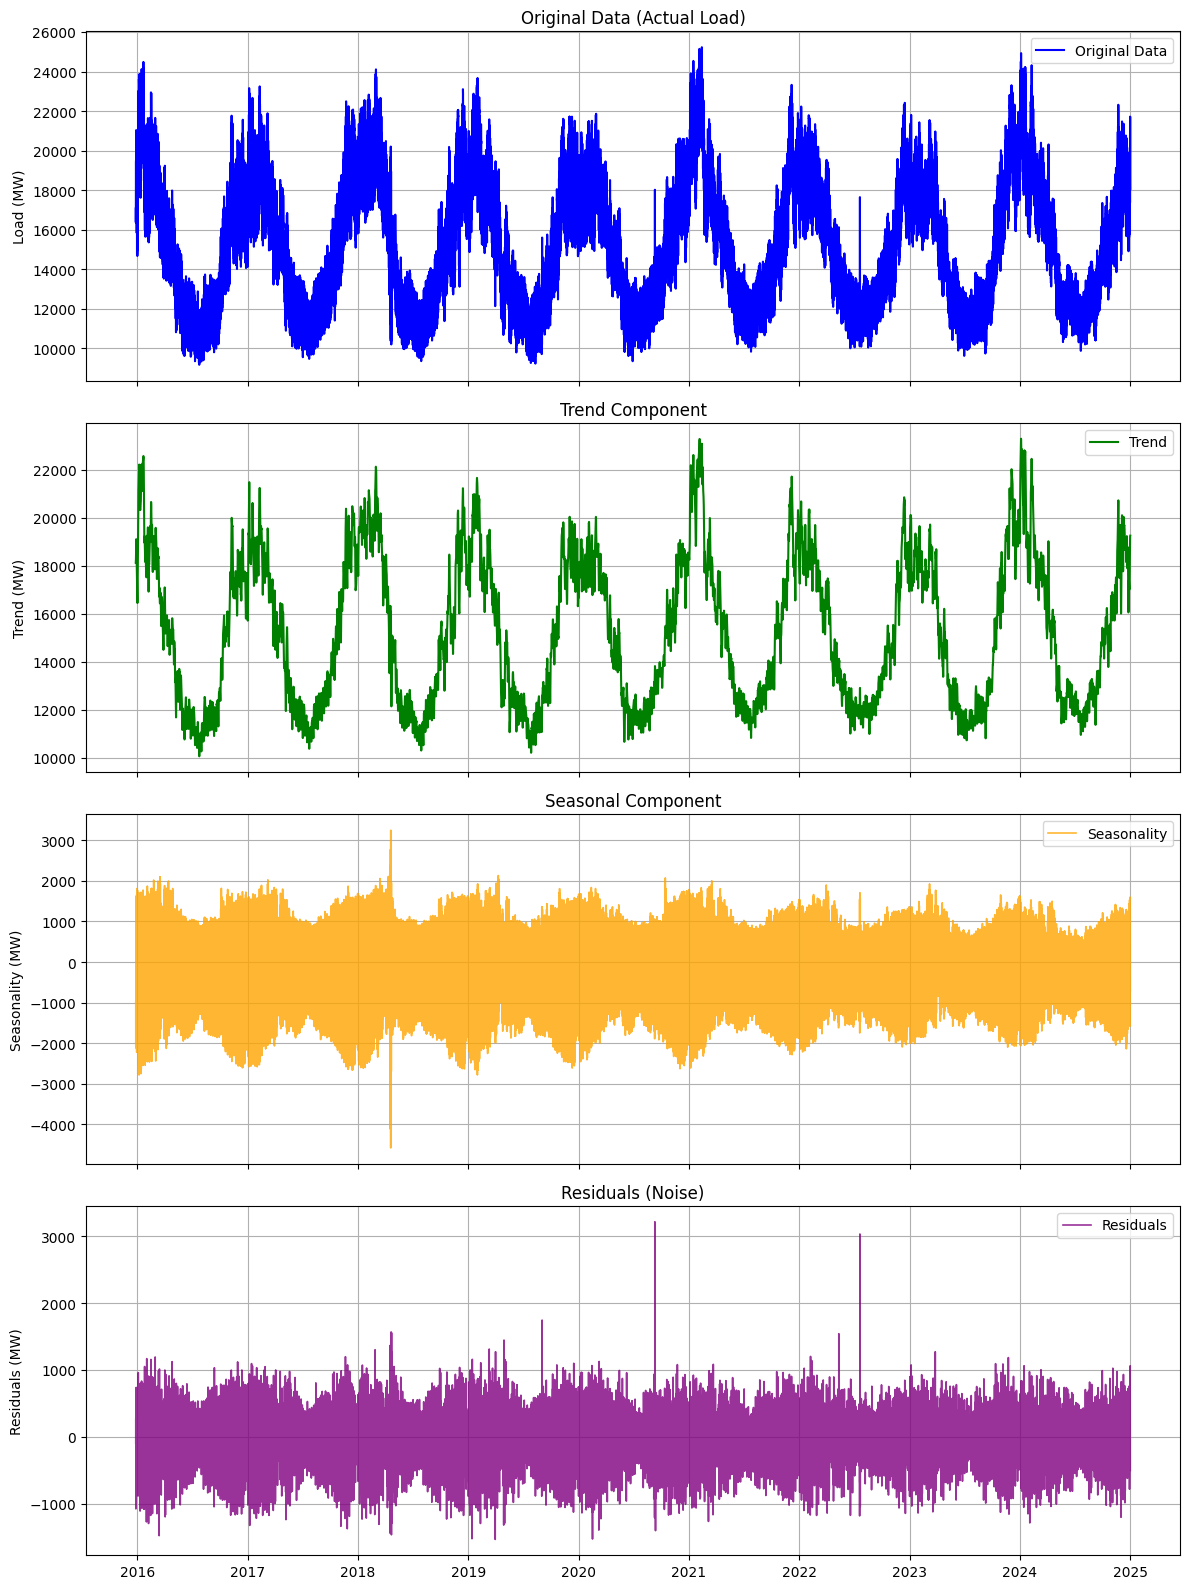

In [15]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Ensure the Timestamp is set as the index and sorted
ts = all_data.set_index('Timestamp').sort_index()

# Choose the time series to decompose (drop missing values if necessary)
series = ts['Actual Load'].dropna()

# Specify the period for the seasonal component.
# For hourly data with daily seasonality, period=24; adjust as needed.
stl = STL(series, period=24)
result = stl.fit()

# Plot each component separately for better clarity
fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

# Original Data
axes[0].plot(series, label='Original Data', color='blue', linewidth=1.5)
axes[0].set_title('Original Data (Actual Load)')
axes[0].set_ylabel('Load (MW)')
axes[0].legend()
axes[0].grid(True)

# Trend Component
axes[1].plot(result.trend, label='Trend', color='green', linewidth=1.5)
axes[1].set_title('Trend Component')
axes[1].set_ylabel('Trend (MW)')
axes[1].legend()
axes[1].grid(True)

# Seasonal Component
axes[2].plot(result.seasonal, label='Seasonality', color='orange', linewidth=1.2, alpha=0.8)
axes[2].set_title('Seasonal Component')
axes[2].set_ylabel('Seasonality (MW)')
axes[2].legend()
axes[2].grid(True)

# Residuals (Noise)
axes[3].plot(result.resid, label='Residuals', color='purple', linewidth=1.2, alpha=0.8)
axes[3].set_title('Residuals (Noise)')
axes[3].set_ylabel('Residuals (MW)')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()


## Methodology

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import joblib
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, ParameterSampler
from reservoirpy.nodes import Reservoir, Ridge
from scipy.stats import uniform, randint

##############################################################################
# 1) DATA LOADING & PREP
##############################################################################

# Suppose `all_data` has: [Timestamp, Actual Load, ...] + optional Forecast Load
df = all_data.dropna().copy()
df.sort_values('Timestamp', inplace=True)

# Example: Extended time-based, lags, etc.
df['Hour'] = df['Timestamp'].dt.hour
df['Weekday'] = df['Timestamp'].dt.weekday
df['Month'] = df['Timestamp'].dt.month
df['Lag_1H'] = df['Actual Load'].shift(1)
df['Lag_24H'] = df['Actual Load'].shift(24)
df.dropna(inplace=True)

# Let’s define a simple single-step target for now


features = [
    'Hour', 'Weekday', 'Month',
    'Lag_1H', 'Lag_24H'
]
X = df[features].values
y = df['Actual Load'].values.reshape(-1,1)

# Single final test holdout
split_idx = int(0.8 * len(X))
df_train = df.iloc[:split_idx]
df_test  = df.iloc[split_idx:]

X_train_all = df_train[features].values
y_train_all = df_train['Actual Load'].values.reshape(-1,1)
X_test_final = df_test[features].values
y_test_final = df_test['Actual Load'].values.reshape(-1,1)

# Scale
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_all_scaled = scaler_X.fit_transform(X_train_all)
y_train_all_scaled = scaler_y.fit_transform(y_train_all)

X_test_final_scaled = scaler_X.transform(X_test_final)
# y_test_final_scaled = scaler_y.transform(y_test_final) # if needed


##############################################################################
# 3) CROSS-VALIDATION + RANDOM SEARCH for ESN
##############################################################################

n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

param_dist = {
    'units': randint(200, 1500),
    'sr': uniform(0.8, 0.8),          # [0.8,1.6]
    'lr': uniform(0.1, 0.4),         # [0.1,0.5]
    'input_scaling': uniform(0.5,1.5)# [0.5,2.0]
}
n_iter = 20  # Try 20 random combos
param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

# We'll store the crossval results in a joblib cache
cache_file = 'esn_cv_results.pkl'
if os.path.exists(cache_file):
    # Load existing cache
    with open(cache_file, 'rb') as f:
        cv_cache = joblib.load(f)
else:
    cv_cache = {}

def train_esn_on_fold(X_train_fold, y_train_fold, X_val_fold, y_val_fold, params):
    """
    Train an ESN with specified hyperparams on a single fold.
    Return MAPE or some chosen error.
    """
    # Scale fold
    scalerX_fold = MinMaxScaler()
    scalerY_fold = MinMaxScaler()
    X_train_fold_scaled = scalerX_fold.fit_transform(X_train_fold)
    y_train_fold_scaled = scalerY_fold.fit_transform(y_train_fold)
    X_val_fold_scaled   = scalerX_fold.transform(X_val_fold)
    # y_val_fold_scaled   = scalerY_fold.transform(y_val_fold) # only if needed for internal metrics

    # Build ESN
    reservoir = Reservoir(
        units=params['units'],
        sr=params['sr'],
        lr=params['lr'],
        input_scaling=params['input_scaling'],
        seed=42
    )
    readout = Ridge(ridge=1e-6)
    esn_model = reservoir >> readout

    esn_model.fit(X_train_fold_scaled, y_train_fold_scaled)
    y_pred_fold_scaled = esn_model.run(X_val_fold_scaled)
    y_pred_fold = scalerY_fold.inverse_transform(y_pred_fold_scaled)

    mae = mean_absolute_error(y_val_fold, y_pred_fold)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    mape = np.mean(np.abs((y_val_fold - y_pred_fold)/y_val_fold)) * 100

    return mae, rmse, mape

cv_results = []
best_mape = float('inf')
best_params = None

for idx, params in enumerate(param_list):
    print(f"ESN Hyperparam set {idx+1}/{len(param_list)}: {params}")

    # We'll create a cache key
    cache_key = tuple(sorted(params.items()))  # So we can store by param set

    if cache_key in cv_cache:
        print(" -> Found in cache, skipping training.")
        mean_mape = cv_cache[cache_key]['mean_mape']
    else:
        # Perform cross val over n_splits
        fold_mapes = []
        for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(X_train_all_scaled)):
            # Build folds
            X_train_fold = X_train_all[train_idx]
            y_train_fold = y_train_all[train_idx].reshape(-1,1)
            X_val_fold   = X_train_all[val_idx]
            y_val_fold   = y_train_all[val_idx].reshape(-1,1)

            # Train on this fold
            mae_, rmse_, mape_ = train_esn_on_fold(X_train_fold, y_train_fold, X_val_fold, y_val_fold, params)
            fold_mapes.append(mape_)

        mean_mape = np.mean(fold_mapes)
        # Store in cache
        cv_cache[cache_key] = {'mean_mape': mean_mape, 'fold_mapes': fold_mapes}

    if mean_mape < best_mape:
        best_mape = mean_mape
        best_params = params

    print(f" -> CV MAPE: {mean_mape:.3f}%")

    # Gather results
    cv_results.append({
        'params': params,
        'mean_mape': mean_mape
    })

# Save the updated cache
with open(cache_file, 'wb') as f:
    joblib.dump(cv_cache, f)

cv_results_df = pd.DataFrame(cv_results).sort_values('mean_mape')
print("\nCV RESULTS:\n", cv_results_df.head(10))
print(f"\nBEST PARAMS: {best_params}, MAPE={best_mape:.3f}%")

##############################################################################
# 4) RETRAIN BEST ESN on Full Training Data + Evaluate on Held-out
##############################################################################
# Scale full training
scalerX_full = MinMaxScaler()
scalerY_full = MinMaxScaler()

X_train_all_scaled = scalerX_full.fit_transform(X_train_all)
y_train_all_scaled = scalerY_full.fit_transform(y_train_all)

X_test_final_scaled = scalerX_full.transform(X_test_final)

# Build ESN with best_params
reservoir = Reservoir(
    units=int(best_params['units']),
    sr=float(best_params['sr']),
    lr=float(best_params['lr']),
    input_scaling=float(best_params['input_scaling']),
    seed=42
)
readout = Ridge(ridge=1e-6)
best_esn = reservoir >> readout

start_time = time.time()
best_esn.fit(X_train_all_scaled, y_train_all_scaled)
train_time = time.time() - start_time

y_pred_scaled = best_esn.run(X_test_final_scaled)
y_pred_final = scalerY_full.inverse_transform(y_pred_scaled)

mae_final = mean_absolute_error(y_test_final, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test_final, y_pred_final))
mape_final = np.mean(np.abs((y_test_final - y_pred_final)/y_test_final)) * 100

print(f"\nFINAL ESN on Test => MAE={mae_final:.2f}, RMSE={rmse_final:.2f}, MAPE={mape_final:.2f}%, trainTime={train_time:.2f}s")

##############################################################################
# 5) PLOT PREDICTIONS
##############################################################################
max_plot = 300
plt.figure(figsize=(10,5))
plt.plot(y_test_final[:max_plot], label='Actual', linewidth=1.5)
plt.plot(y_pred_final[:max_plot], label='ESN', alpha=0.7)
plt.title('ESN Predictions on Held-Out Test')
plt.xlabel('Time Step')
plt.ylabel('Load')
plt.legend()
plt.tight_layout()
plt.savefig('plots/final_esn_predictions.png', dpi=300)
plt.show()


ESN Hyperparam set 1/20: {'input_scaling': np.float64(1.0618101782710436), 'lr': np.float64(0.4802857225639665), 'sr': np.float64(1.385595153449124), 'units': 1244}
 -> Found in cache, skipping training.
 -> CV MAPE: 0.918%
ESN Hyperparam set 2/20: {'input_scaling': np.float64(0.7340279606636548), 'lr': np.float64(0.16239780813448107), 'sr': np.float64(0.8464668897345596), 'units': 287}
 -> Found in cache, skipping training.
 -> CV MAPE: 1.282%
ESN Hyperparam set 3/20: {'input_scaling': np.float64(1.0005629167085328), 'lr': np.float64(0.1571467271687763), 'sr': np.float64(1.3207107783590823), 'units': 969}
 -> Found in cache, skipping training.
 -> CV MAPE: 1.853%
ESN Hyperparam set 4/20: {'input_scaling': np.float64(1.582998158400237), 'lr': np.float64(0.4754210836063001), 'sr': np.float64(0.8006230126728116), 'units': 1155}
 -> Found in cache, skipping training.
 -> CV MAPE: 0.879%
ESN Hyperparam set 5/20: {'input_scaling': np.float64(0.7751067647801507), 'lr': np.float64(0.221696897

Running Model-0:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# 6) EXTENDED LSTM and CNN+LSTM in PyTorch with Joblib Parallel + Caching
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
from scipy.stats import ttest_rel
import numpy as np
import itertools
import random
import copy
import matplotlib.pyplot as plt

from joblib import Parallel, delayed, Memory

# Create a directory for caching (if it doesn't exist, joblib will create it)
memory = Memory(location="./joblib_cache", verbose=1)

# We assume you already have:
# - X_train_all_scaled, y_train_all_scaled -> your scaled training data (numpy)
# - X_test_final_scaled                   -> your scaled test data (numpy)
# - y_test_final                          -> your unscaled test labels for final metrics (numpy)
# - scalerY_full                          -> your fitted MinMaxScaler for 'y'
# - best_esn predictions in y_pred_final  -> your ESN predictions on the test set (numpy)

# 6.1) Prepare Data for PyTorch
X_train_torch_base = torch.from_numpy(X_train_all_scaled).float()
y_train_torch_base = torch.from_numpy(y_train_all_scaled).float()
X_test_torch = torch.from_numpy(X_test_final_scaled).float()

def reshape_for_lstm(X_torch):
    # e.g. (N, num_features) => (N, 1, num_features)
    return X_torch.unsqueeze(1)

# 6.2) Model Classes (LSTMModel, CNNLSTMModel)
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, output_dim=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        out = self.fc(last_out)
        return out

class CNNLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=1)
        self.pool = nn.MaxPool1d(kernel_size=1)
        self.lstm = nn.LSTM(32, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (batch_size, seq_len=1, input_dim)
        x = x.transpose(1, 2)  # => (batch, input_dim, seq_len=1)
        x = self.conv1(x)      # => (batch, 32, seq_len=1)
        x = self.pool(x)       # => (batch, 32, seq_len=1)
        x = x.transpose(1, 2)  # => (batch, seq_len=1, 32)
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        out = self.fc(last_out)
        return out

# 6.3) CACHED Helper Function: Train/Eval
@memory.cache  # joblib cache decorator
def train_and_evaluate_model(
    model_type='lstm',        # 'lstm' or 'cnn'
    hidden_dim=64,
    num_layers=1,
    learning_rate=1e-3,
    epochs=10,
    batch_size=64,
    seed=42
):
    """
    Trains either LSTM or CNN+LSTM on a single train set,
    returns final predictions on the test set and metrics.
    Caching is applied: if the same (model_type, hidden_dim, num_layers, learning_rate, epochs, batch_size, seed)
    is called again, joblib will skip re-computing and load from cache.
    """

    # Set random seeds for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Prepare data
    X_train_torch = reshape_for_lstm(X_train_torch_base)
    y_train_torch = y_train_torch_base

    # DataLoader
    train_dataset = torch.utils.data.TensorDataset(X_train_torch, y_train_torch)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    input_dim = X_train_all_scaled.shape[1]

    # Build model
    if model_type == 'lstm':
        model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=1)
    else:
        model = CNNLSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train loop
    model.train()
    for epoch_i in range(epochs):
        total_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            if y_batch.dim() == 1:
                y_batch = y_batch.unsqueeze(1)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)
        # epoch_loss = total_loss / len(train_loader.dataset)
        # (Optional print) print(f"[{model_type.upper()}] Epoch {epoch_i+1}/{epochs}, Loss={epoch_loss:.6f}")

    # Evaluate on test
    model.eval()
    with torch.no_grad():
        y_pred_test = model(reshape_for_lstm(X_test_torch))
    y_pred_test_np = y_pred_test.detach().numpy()

    # Inverse transform
    y_pred_unscaled = scalerY_full.inverse_transform(y_pred_test_np)

    # Compute errors
    mae = np.mean(np.abs(y_test_final - y_pred_unscaled))
    rmse = np.sqrt(np.mean((y_test_final - y_pred_unscaled)**2))
    mape = np.mean(np.abs((y_test_final - y_pred_unscaled) / y_test_final)) * 100
    r2 = r2_score(y_test_final, y_pred_unscaled)

    metrics = {
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'r2': r2,
        'preds': y_pred_unscaled
    }
    return metrics

# 6.4) Minimal Hyperparam Search + Repeated Seeds with joblib Parallel
import math

lstm_param_grid = {
    'hidden_dim': [32, 64],
    'num_layers': [1, 2],
    'learning_rate': [1e-3, 3e-4],
    'epochs': [10],
    'batch_size': [64],
}
cnn_param_grid = {
    'hidden_dim': [32, 64],
    'learning_rate': [1e-3, 3e-4],
    'epochs': [10],
    'batch_size': [64],
}

def param_grid_to_list(param_grid):
    keys = list(param_grid.keys())
    combos = []
    for values in itertools.product(*[param_grid[k] for k in keys]):
        combos.append(dict(zip(keys, values)))
    return combos

lstm_params_list = param_grid_to_list(lstm_param_grid)
cnn_params_list = param_grid_to_list(cnn_param_grid)

repetition_seeds = [42, 43, 44]

print("\n--- LSTM HYPERPARAM SEARCH (Parallel) ---")

def run_lstm_config(pset):
    # We'll average metrics over repeated seeds
    mapes, maes, rmses, r2s = [], [], [], []
    for sd in repetition_seeds:
        metrics = train_and_evaluate_model(
            model_type='lstm',
            hidden_dim=pset['hidden_dim'],
            num_layers=pset.get('num_layers', 1),
            learning_rate=pset['learning_rate'],
            epochs=pset['epochs'],
            batch_size=pset['batch_size'],
            seed=sd
        )
        mapes.append(metrics['mape'])
        maes.append(metrics['mae'])
        rmses.append(metrics['rmse'])
        r2s.append(metrics['r2'])
    mean_mape = np.mean(mapes)
    mean_mae  = np.mean(maes)
    mean_rmse = np.mean(rmses)
    mean_r2   = np.mean(r2s)
    return pset, (mean_mape, mean_mae, mean_rmse, mean_r2)

lstm_results = Parallel(n_jobs=-1, verbose=5)(
    delayed(run_lstm_config)(pset) for pset in lstm_params_list
)

best_lstm_mape = float('inf')
best_lstm_params = None
best_lstm_metrics = None

for (pset, (mean_mape, mean_mae, mean_rmse, mean_r2)) in lstm_results:
    print(f"Params={pset}, Seeds avg => MAPE={mean_mape:.3f}%, MAE={mean_mae:.2f}, RMSE={mean_rmse:.2f}, R2={mean_r2:.4f}")
    if mean_mape < best_lstm_mape:
        best_lstm_mape = mean_mape
        best_lstm_params = copy.deepcopy(pset)
        best_lstm_metrics = {
            'mae': mean_mae, 'rmse': mean_rmse, 'mape': mean_mape, 'r2': mean_r2
        }

print("\nBEST LSTM PARAMS:", best_lstm_params, "=>", best_lstm_metrics)

print("\n--- CNN+LSTM HYPERPARAM SEARCH (Parallel) ---")

def run_cnn_config(pset):
    mapes, maes, rmses, r2s = [], [], [], []
    for sd in repetition_seeds:
        metrics = train_and_evaluate_model(
            model_type='cnn',
            hidden_dim=pset['hidden_dim'],
            learning_rate=pset['learning_rate'],
            epochs=pset['epochs'],
            batch_size=pset['batch_size'],
            seed=sd
        )
        mapes.append(metrics['mape'])
        maes.append(metrics['mae'])
        rmses.append(metrics['rmse'])
        r2s.append(metrics['r2'])
    mean_mape = np.mean(mapes)
    mean_mae  = np.mean(maes)
    mean_rmse = np.mean(rmses)
    mean_r2   = np.mean(r2s)
    return pset, (mean_mape, mean_mae, mean_rmse, mean_r2)

cnn_results = Parallel(n_jobs=-1, verbose=5)(
    delayed(run_cnn_config)(pset) for pset in cnn_params_list
)

best_cnn_mape = float('inf')
best_cnn_params = None
best_cnn_metrics = None

for (pset, (mean_mape, mean_mae, mean_rmse, mean_r2)) in cnn_results:
    print(f"Params={pset}, Seeds avg => MAPE={mean_mape:.3f}%, MAE={mean_mae:.2f}, RMSE={mean_rmse:.2f}, R2={mean_r2:.4f}")
    if mean_mape < best_cnn_mape:
        best_cnn_mape = mean_mape
        best_cnn_params = copy.deepcopy(pset)
        best_cnn_metrics = {
            'mae': mean_mae, 'rmse': mean_rmse, 'mape': mean_mape, 'r2': mean_r2
        }

print("\nBEST CNN+LSTM PARAMS:", best_cnn_params, "=>", best_cnn_metrics)


# 6.5) Retrain LSTM & CNN+LSTM + multiple seeds => final preds
print("\n--- Retraining FINAL LSTM with best params, repeated seeds ---")
lstm_final_preds_list = []
for sd in repetition_seeds:
    final_metrics = train_and_evaluate_model(
        model_type='lstm',
        hidden_dim=best_lstm_params['hidden_dim'],
        num_layers=best_lstm_params.get('num_layers', 1),
        learning_rate=best_lstm_params['learning_rate'],
        epochs=best_lstm_params['epochs'],
        batch_size=best_lstm_params['batch_size'],
        seed=sd
    )
    lstm_final_preds_list.append(final_metrics['preds'])
y_pred_lstm_final = lstm_final_preds_list[-1]  # or average across seeds if desired

print("\n--- Retraining FINAL CNN+LSTM with best params, repeated seeds ---")
cnn_final_preds_list = []
for sd in repetition_seeds:
    final_metrics = train_and_evaluate_model(
        model_type='cnn',
        hidden_dim=best_cnn_params['hidden_dim'],
        learning_rate=best_cnn_params['learning_rate'],
        epochs=best_cnn_params['epochs'],
        batch_size=best_cnn_params['batch_size'],
        seed=sd
    )
    cnn_final_preds_list.append(final_metrics['preds'])
y_pred_cnnlstm_final = cnn_final_preds_list[-1]


# 6.6)Metrics + T-test vs. ESN
def compute_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, mape, r2

# Suppose your ESN predictions are in y_pred_final
mae_esn, rmse_esn, mape_esn, r2_esn = compute_metrics(y_test_final, y_pred_final)
mae_lstmF, rmse_lstmF, mape_lstmF, r2_lstmF = compute_metrics(y_test_final, y_pred_lstm_final)
mae_cnnF, rmse_cnnF, mape_cnnF, r2_cnnF = compute_metrics(y_test_final, y_pred_cnnlstm_final)

print("\nFINAL COMPARISON:")
print(f"ESN     => MAE={mae_esn:.2f},   RMSE={rmse_esn:.2f},   MAPE={mape_esn:.2f}%,  R2={r2_esn:.4f}")
print(f"LSTM    => MAE={mae_lstmF:.2f}, RMSE={rmse_lstmF:.2f}, MAPE={mape_lstmF:.2f}%,R2={r2_lstmF:.4f}")
print(f"CNN+LSTM=> MAE={mae_cnnF:.2f},  RMSE={rmse_cnnF:.2f},  MAPE={mape_cnnF:.2f}%, R2={r2_cnnF:.4f}")

from scipy.stats import ttest_rel

# Compare ESN vs LSTM
esn_errors  = np.abs(y_test_final - y_pred_final).flatten()
lstm_errors = np.abs(y_test_final - y_pred_lstm_final).flatten()
t_stat_lstm, p_val_lstm = ttest_rel(esn_errors, lstm_errors)
print(f"\nPaired t-test ESN vs. LSTM: t={t_stat_lstm:.3f}, p-value={p_val_lstm:.4f}")

# Compare ESN vs CNN+LSTM
cnn_errors = np.abs(y_test_final - y_pred_cnnlstm_final).flatten()
t_stat_cnn, p_val_cnn = ttest_rel(esn_errors, cnn_errors)
print(f"Paired t-test ESN vs. CNN+LSTM: t={t_stat_cnn:.3f}, p-value={p_val_cnn:.4f}")



--- LSTM HYPERPARAM SEARCH (Parallel) ---


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.0s finished


Params={'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.001, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.455%, MAE=219.40, RMSE=294.76, R2=0.9916
Params={'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.0003, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.480%, MAE=223.48, RMSE=301.66, R2=0.9912
Params={'hidden_dim': 32, 'num_layers': 2, 'learning_rate': 0.001, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.593%, MAE=242.23, RMSE=323.72, R2=0.9897
Params={'hidden_dim': 32, 'num_layers': 2, 'learning_rate': 0.0003, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.459%, MAE=221.19, RMSE=300.27, R2=0.9913
Params={'hidden_dim': 64, 'num_layers': 1, 'learning_rate': 0.001, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.497%, MAE=227.02, RMSE=304.98, R2=0.9910
Params={'hidden_dim': 64, 'num_layers': 1, 'learning_rate': 0.0003, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.457%, MAE=220.60, RMSE=300.85, R2=0.9912
Params={'hidden_dim': 64, 'num_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished


Params={'hidden_dim': 32, 'learning_rate': 0.001, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.365%, MAE=206.51, RMSE=269.38, R2=0.9930
Params={'hidden_dim': 32, 'learning_rate': 0.0003, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.444%, MAE=218.43, RMSE=293.19, R2=0.9917
Params={'hidden_dim': 64, 'learning_rate': 0.001, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.442%, MAE=217.71, RMSE=281.69, R2=0.9923
Params={'hidden_dim': 64, 'learning_rate': 0.0003, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.442%, MAE=217.77, RMSE=290.49, R2=0.9918

BEST CNN+LSTM PARAMS: {'hidden_dim': 32, 'learning_rate': 0.001, 'epochs': 10, 'batch_size': 64} => {'mae': np.float64(206.51198857944814), 'rmse': np.float64(269.3846823475886), 'mape': np.float64(1.365017490472067), 'r2': np.float64(0.9929729572149945)}

--- Retraining FINAL LSTM with best params, repeated seeds ---

--- Retraining FINAL CNN+LSTM with best params, repeated seeds ---

FINAL COMPARISON:
ESN     => MAE

Prophet Trial 1/15: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 10, 'fourier_order_weekly': 5, 'fourier_order_daily': 10}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-1771780452.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0      16986.0  2015     12   28     1   
8667  2015-12-28 02:00:00        16867.0      16867.0  2015     12   28     2   
8668  2015-12-28 03:00:00        168

14:51:05 - cmdstanpy - INFO - Chain [1] start processing
14:51:13 - cmdstanpy - INFO - Chain [1] done processing


______________________________________train_and_evaluate_prophet - 14.6s, 0.2min
 -> MAPE=1.17% | MAE=172.21 | RMSE=229.53
Prophet Trial 2/15: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 10, 'fourier_order_weekly': 5, 'fourier_order_daily': 10}
 -> MAPE=1.17% | MAE=172.21 | RMSE=229.53
Prophet Trial 3/15: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 10, 'fourier_order_weekly': 5, 'fourier_order_daily': 10}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-17717804

14:51:19 - cmdstanpy - INFO - Chain [1] start processing
14:51:25 - cmdstanpy - INFO - Chain [1] done processing


______________________________________train_and_evaluate_prophet - 12.3s, 0.2min
 -> MAPE=1.17% | MAE=172.24 | RMSE=229.56
Prophet Trial 4/15: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 20, 'fourier_order_weekly': 5, 'fourier_order_daily': 5}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-1771780452.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0      16986.0  2015     12   28     1 

14:51:32 - cmdstanpy - INFO - Chain [1] start processing
14:51:39 - cmdstanpy - INFO - Chain [1] done processing


______________________________________train_and_evaluate_prophet - 13.0s, 0.2min
 -> MAPE=1.21% | MAE=178.44 | RMSE=234.03
Prophet Trial 5/15: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 20, 'fourier_order_weekly': 5, 'fourier_order_daily': 5}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-1771780452.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0      16986.0  2015     12   28     1

14:51:46 - cmdstanpy - INFO - Chain [1] start processing
14:51:52 - cmdstanpy - INFO - Chain [1] done processing


______________________________________train_and_evaluate_prophet - 13.3s, 0.2min
 -> MAPE=1.21% | MAE=178.39 | RMSE=233.98
Prophet Trial 6/15: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 10, 'fourier_order_weekly': 5, 'fourier_order_daily': 5}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-1771780452.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0      16986.0  2015     12   28    

14:51:58 - cmdstanpy - INFO - Chain [1] start processing
14:52:06 - cmdstanpy - INFO - Chain [1] done processing


______________________________________train_and_evaluate_prophet - 14.1s, 0.2min
 -> MAPE=1.21% | MAE=178.06 | RMSE=233.71
Prophet Trial 7/15: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 20, 'fourier_order_weekly': 5, 'fourier_order_daily': 3}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-1771780452.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0      16986.0  2015     12   28     

14:52:13 - cmdstanpy - INFO - Chain [1] start processing
14:52:20 - cmdstanpy - INFO - Chain [1] done processing


______________________________________train_and_evaluate_prophet - 13.0s, 0.2min
 -> MAPE=1.28% | MAE=189.39 | RMSE=243.81
Prophet Trial 8/15: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 20, 'fourier_order_weekly': 5, 'fourier_order_daily': 5}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-1771780452.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0      16986.0  2015     12   28     1

14:52:26 - cmdstanpy - INFO - Chain [1] start processing
14:52:32 - cmdstanpy - INFO - Chain [1] done processing


______________________________________train_and_evaluate_prophet - 12.7s, 0.2min
 -> MAPE=1.21% | MAE=178.28 | RMSE=233.88
Prophet Trial 9/15: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 20, 'fourier_order_weekly': 5, 'fourier_order_daily': 3}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-1771780452.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0      16986.0  2015     12   28     1  

14:52:39 - cmdstanpy - INFO - Chain [1] start processing
14:52:44 - cmdstanpy - INFO - Chain [1] done processing


______________________________________train_and_evaluate_prophet - 11.5s, 0.2min
 -> MAPE=1.29% | MAE=189.82 | RMSE=244.19
Prophet Trial 10/15: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 20, 'fourier_order_weekly': 5, 'fourier_order_daily': 3}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-1771780452.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0      16986.0  2015     12   28     

14:52:51 - cmdstanpy - INFO - Chain [1] start processing
14:52:57 - cmdstanpy - INFO - Chain [1] done processing


______________________________________train_and_evaluate_prophet - 12.8s, 0.2min
 -> MAPE=1.28% | MAE=189.37 | RMSE=243.79
Prophet Trial 11/15: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 10, 'fourier_order_weekly': 10, 'fourier_order_daily': 10}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-1771780452.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0      16986.0  2015     12   28    

14:53:04 - cmdstanpy - INFO - Chain [1] start processing
14:53:11 - cmdstanpy - INFO - Chain [1] done processing


______________________________________train_and_evaluate_prophet - 14.1s, 0.2min
 -> MAPE=1.17% | MAE=172.43 | RMSE=227.30
Prophet Trial 12/15: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 10, 'fourier_order_weekly': 5, 'fourier_order_daily': 5}
 -> MAPE=1.21% | MAE=178.06 | RMSE=233.71
Prophet Trial 13/15: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 20, 'fourier_order_weekly': 5, 'fourier_order_daily': 5}
 -> MAPE=1.21% | MAE=178.41 | RMSE=234.00
Prophet Trial 14/15: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoin

14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:26 - cmdstanpy - INFO - Chain [1] done processing


______________________________________train_and_evaluate_prophet - 14.6s, 0.2min
 -> MAPE=1.20% | MAE=177.95 | RMSE=231.73
Prophet Trial 15/15: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 10, 'fourier_order_weekly': 5, 'fourier_order_daily': 3}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-1771780452.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0      16986.0  2015     12   28     1

14:53:32 - cmdstanpy - INFO - Chain [1] start processing
14:53:36 - cmdstanpy - INFO - Chain [1] done processing


_______________________________________train_and_evaluate_prophet - 9.6s, 0.2min
 -> MAPE=1.29% | MAE=189.90 | RMSE=244.33

✅ Best Prophet Config:
{'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 10, 'fourier_order_weekly': 10, 'fourier_order_daily': 10}

📊 Final Model Comparison:
                  MAE        RMSE  MAPE (%)        R²
ESN       140.855685  185.017630  0.942811  0.996688
LSTM      221.366585  295.692833  1.471762  0.991541
CNN+LSTM  207.077008  269.338387  1.356953  0.992982
Prophet   172.426106  227.299169  1.166219  0.995002


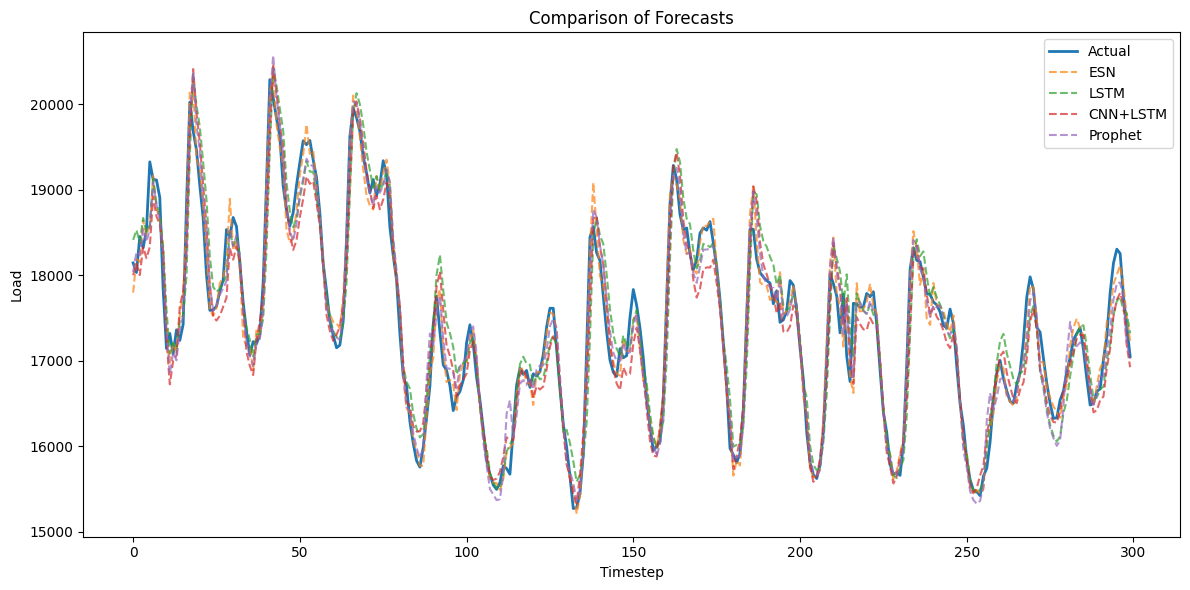

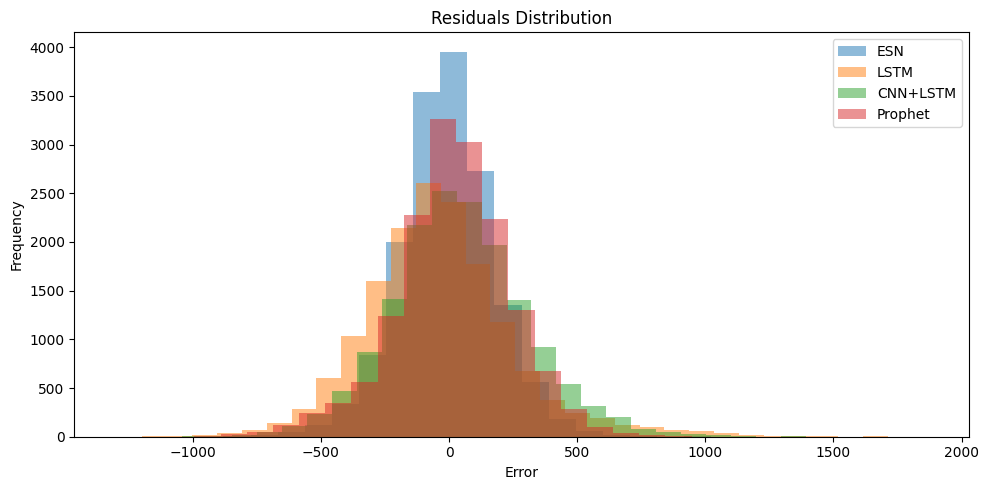

In [ ]:
# 7) PROPHET MODEL IMPLEMENTATION
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
import time
from joblib import Memory
from itertools import product
import random
from scipy.stats import ttest_rel
import os

# Suppress prophet warnings
warnings.filterwarnings('ignore')

# Ensure plot directory exists
os.makedirs("plots", exist_ok=True)

# Create joblib cache for prophet
prophet_memory = Memory(location="./joblib_cache", verbose=1)

# 7.1) Prepare Data for Prophet
def prepare_prophet_data(df, target_col='Actual Load', add_features=True):
    """
    Prepare data in the format required by Prophet (ds, y) with additional features.
    Includes time features and lagged features if available.
    """
    prophet_df = df[['Timestamp', target_col]].copy()
    prophet_df.columns = ['ds', 'y']
    
    if add_features:
        if 'Hour' in df.columns:
            prophet_df['hour'] = df['Hour']
        if 'Weekday' in df.columns:
            prophet_df['weekday'] = df['Weekday']
        if 'Month' in df.columns:
            prophet_df['month'] = df['Month']
        if 'Lag_1H' in df.columns:
            prophet_df['lag_1h'] = df['Lag_1H']
        if 'Lag_24H' in df.columns:
            prophet_df['lag_24h'] = df['Lag_24H']
        if 'Temperature' in df.columns:
            prophet_df['temperature'] = df['Temperature']
        
        additional_cols = [col for col in df.columns if col.startswith('Feature_')]
        for col in additional_cols:
            prophet_df[col.lower()] = df[col]
    
    return prophet_df

# 7.2) Train and Evaluate Prophet with Cache
@prophet_memory.cache
def train_and_evaluate_prophet(df_train, df_test, **kwargs):
    """
    Train Prophet with extended features and return predictions + metrics.
    Uses caching for faster repeated tuning.
    """
    train_prophet = prepare_prophet_data(df_train, add_features=kwargs.get('add_lag_features', True))
    test_prophet = prepare_prophet_data(df_test, add_features=kwargs.get('add_lag_features', True))
    
    model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=kwargs['changepoint_prior_scale'],
        seasonality_prior_scale=kwargs['seasonality_prior_scale'],
        holidays_prior_scale=kwargs['holidays_prior_scale'],
        interval_width=0.95
    )

    # Custom seasonality
    if kwargs.get("yearly_seasonality"): model.add_seasonality('yearly', 365.25, fourier_order=kwargs['fourier_order_yearly'])
    if kwargs.get("weekly_seasonality"): model.add_seasonality('weekly', 7, fourier_order=kwargs['fourier_order_weekly'])
    if kwargs.get("daily_seasonality"): model.add_seasonality('daily', 1, fourier_order=kwargs['fourier_order_daily'])

    if kwargs.get("add_country_holidays", False):
        model.add_country_holidays("NO")

    if kwargs.get("add_lag_features", True):
        for reg in ['lag_1h', 'lag_24h', 'hour', 'weekday', 'month', 'temperature']:
            if reg in train_prophet.columns:
                model.add_regressor(reg)
        for reg in [c for c in train_prophet.columns if c.startswith("feature_")]:
            model.add_regressor(reg)
    
    start_time = time.time()
    model.fit(train_prophet)
    train_time = time.time() - start_time

    forecast = model.predict(test_prophet)
    y_pred = forecast['yhat'].values.reshape(-1, 1)
    y_true = test_prophet['y'].values.reshape(-1, 1)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    return {
        'mae': mae, 'rmse': rmse, 'mape': mape, 'r2': r2,
        'preds': y_pred, 'forecast': forecast, 'train_time': train_time
    }, model

# 7.3) Random Search Over Prophet Hyperparameters
def run_prophet_search(df_train, df_test, n_iter=15):
    """
    Randomized hyperparameter search for Prophet
    """
    param_space = {
        'yearly_seasonality': [True],
        'weekly_seasonality': [True],
        'daily_seasonality': [True],
        'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1],
        'seasonality_prior_scale': [0.1, 1.0, 10.0],
        'holidays_prior_scale': [1.0, 10.0],
        'add_country_holidays': [True],
        'add_lag_features': [True],
        'fourier_order_yearly': [10, 20],
        'fourier_order_weekly': [5, 10],
        'fourier_order_daily': [3, 5, 10]
    }

    best_mape = float('inf')
    best_params = {}
    best_result = {}

    for i in range(n_iter):
        params = {k: random.choice(v) for k, v in param_space.items()}
        print(f"Prophet Trial {i+1}/{n_iter}: {params}")
        try:
            metrics, _ = train_and_evaluate_prophet(df_train, df_test, **params)
            print(f" -> MAPE={metrics['mape']:.2f}% | MAE={metrics['mae']:.2f} | RMSE={metrics['rmse']:.2f}")
            if metrics['mape'] < best_mape:
                best_mape = metrics['mape']
                best_params = params.copy()
                best_result = metrics.copy()
        except Exception as e:
            print(f" -> Error: {str(e)}")

    print("\n✅ Best Prophet Config:")
    print(best_params)
    return best_params, best_result

# 7.4) Train Prophet Model + Save Plots
def train_final_prophet_model(df_train, df_test, best_params):
    """
    Train final Prophet with best config and generate all evaluation plots.
    """
    metrics, model = train_and_evaluate_prophet(df_train, df_test, **best_params)
    forecast = metrics['forecast']
    
    # Save forecast components
    model.plot_components(forecast)
    plt.tight_layout()
    plt.savefig("plots/prophet_components.png", dpi=300)
    plt.close()

    # Save forecast curve
    model.plot(forecast)
    plt.tight_layout()
    plt.savefig("plots/prophet_forecast.png", dpi=300)
    plt.close()
    
    return metrics['preds'], model, forecast

# 7.5)Comparison Across Models
def compare_all_models(y_test, esn_pred, lstm_pred, cnn_pred, prophet_pred):
    """
    Compare ESN, LSTM, CNN+LSTM and Prophet using metrics + plots
    """
    def calc_metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        r2 = r2_score(y_true, y_pred)
        return mae, rmse, mape, r2

    names = ['ESN', 'LSTM', 'CNN+LSTM', 'Prophet']
    preds = [esn_pred, lstm_pred, cnn_pred, prophet_pred]
    metrics = [calc_metrics(y_test, p) for p in preds]

    df = pd.DataFrame(metrics, columns=['MAE', 'RMSE', 'MAPE (%)', 'R²'], index=names)
    print("\n📊 Final Model Comparison:\n", df)

    # Save model comparison plot
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[:300], label='Actual', linewidth=2)
    for name, pred in zip(names, preds):
        plt.plot(pred[:300], label=name, linestyle='--', alpha=0.7)
    plt.title("Comparison of Forecasts")
    plt.xlabel("Timestep")
    plt.ylabel("Load")
    plt.legend()
    plt.tight_layout()
    plt.savefig("plots/all_models_comparison.png", dpi=300)
    plt.show()

    # Save error histogram
    plt.figure(figsize=(10, 5))
    for name, pred in zip(names, preds):
        err = (y_test - pred).flatten()
        plt.hist(err, bins=30, alpha=0.5, label=name)
    plt.title("Residuals Distribution")
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.savefig("plots/error_distribution.png", dpi=300)
    plt.show()

# 8) MAIN EXECUTION FLOW 
if __name__ == "__main__":
    # Use your existing variables here (e.g., df_train, df_test, y_test_final, etc.)
    
    best_prophet_params, best_metrics = run_prophet_search(df_train, df_test, n_iter=15)
    y_pred_prophet_final, prophet_model, prophet_forecast = train_final_prophet_model(df_train, df_test, best_prophet_params)

    # Plot comparison with existing models (assumed already run)
    compare_all_models(
        y_test_final,
        y_pred_final,
        y_pred_lstm_final,
        y_pred_cnnlstm_final,
        y_pred_prophet_final
    )


## Plots

ESN      => MAE=140.86, RMSE=185.02, MAPE=0.94%, R2=0.9967
LSTM     => MAE=221.37, RMSE=295.69, MAPE=1.47%, R2=0.9915
CNN+LSTM => MAE=207.08, RMSE=269.34, MAPE=1.36%, R2=0.9930
Prophet  => MAE=172.43, RMSE=227.30, MAPE=1.17%, R2=0.9950


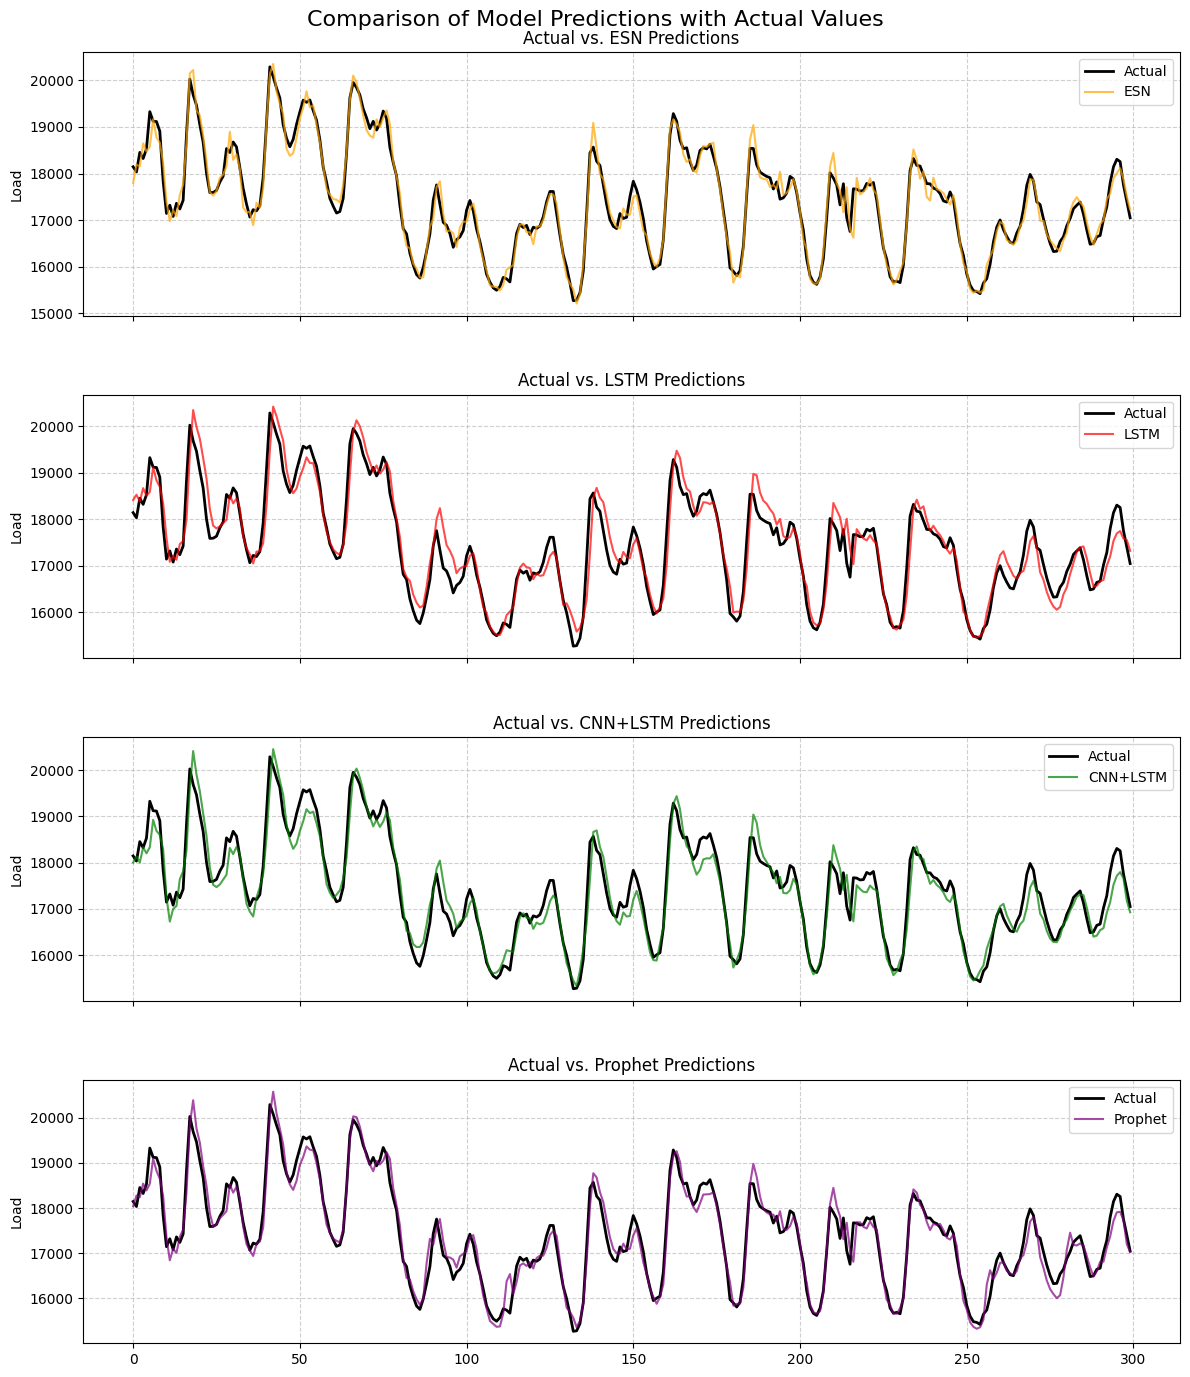

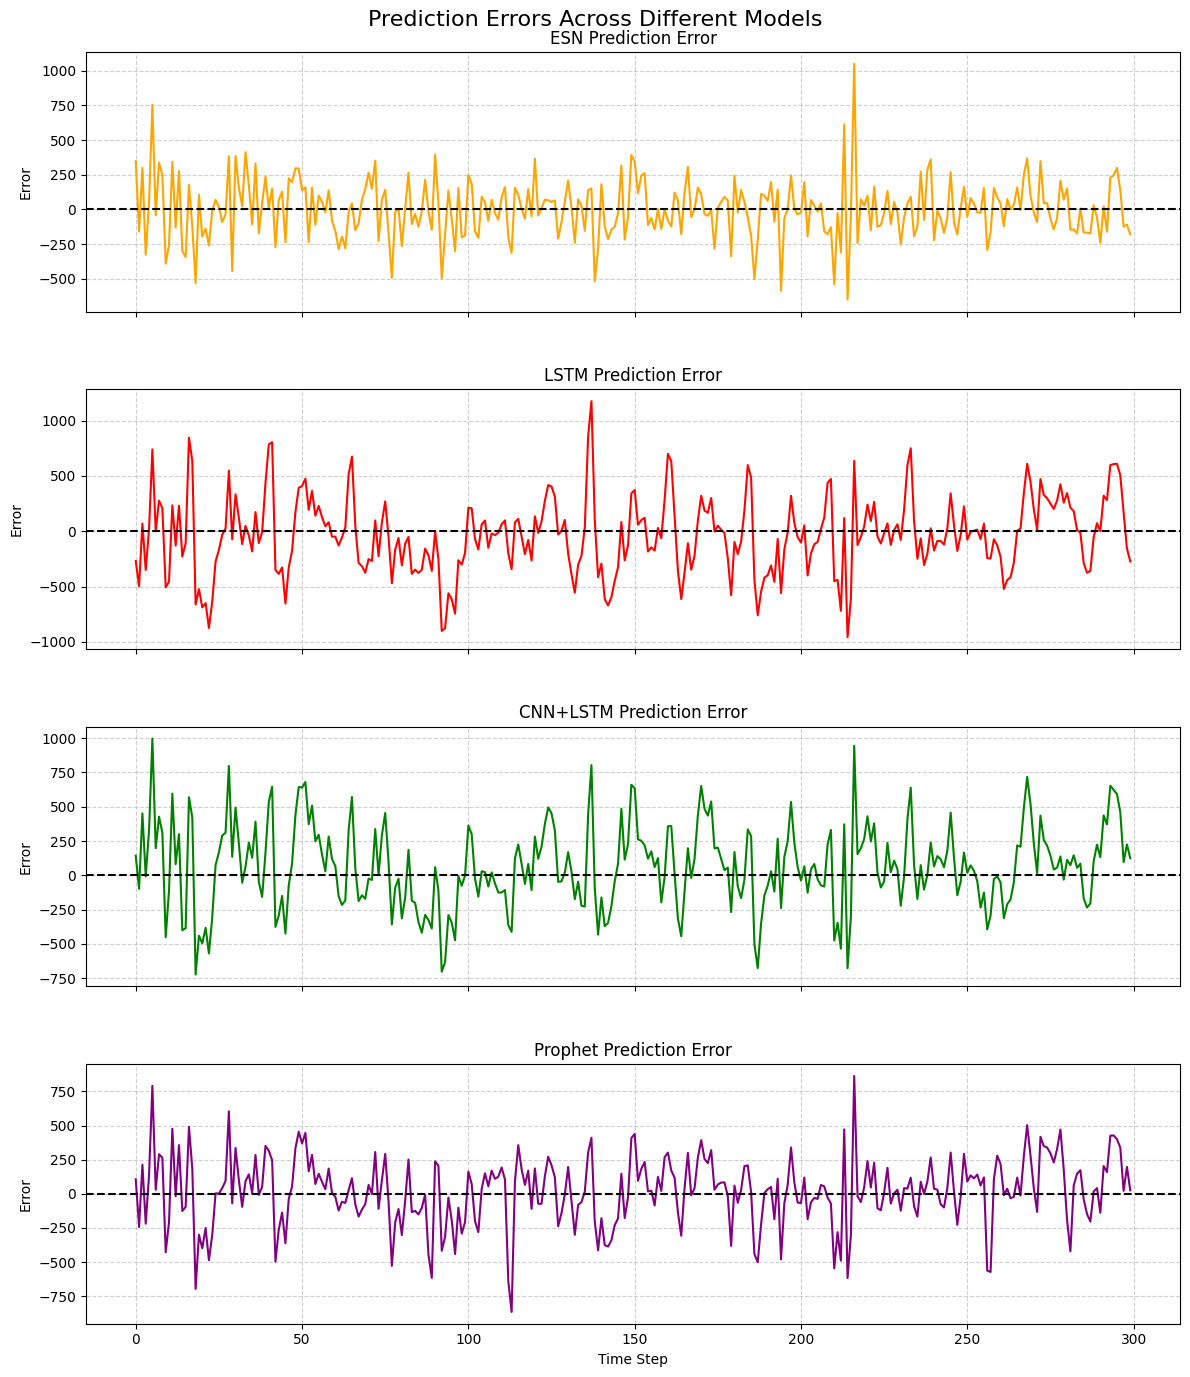

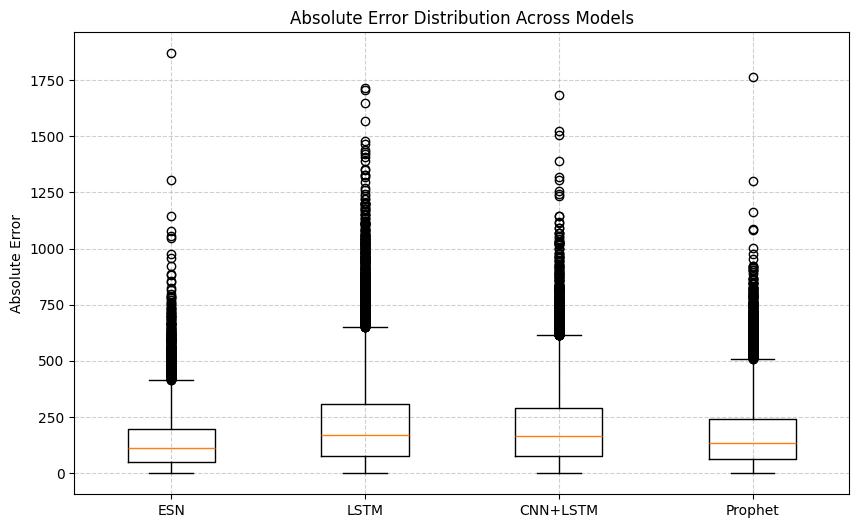

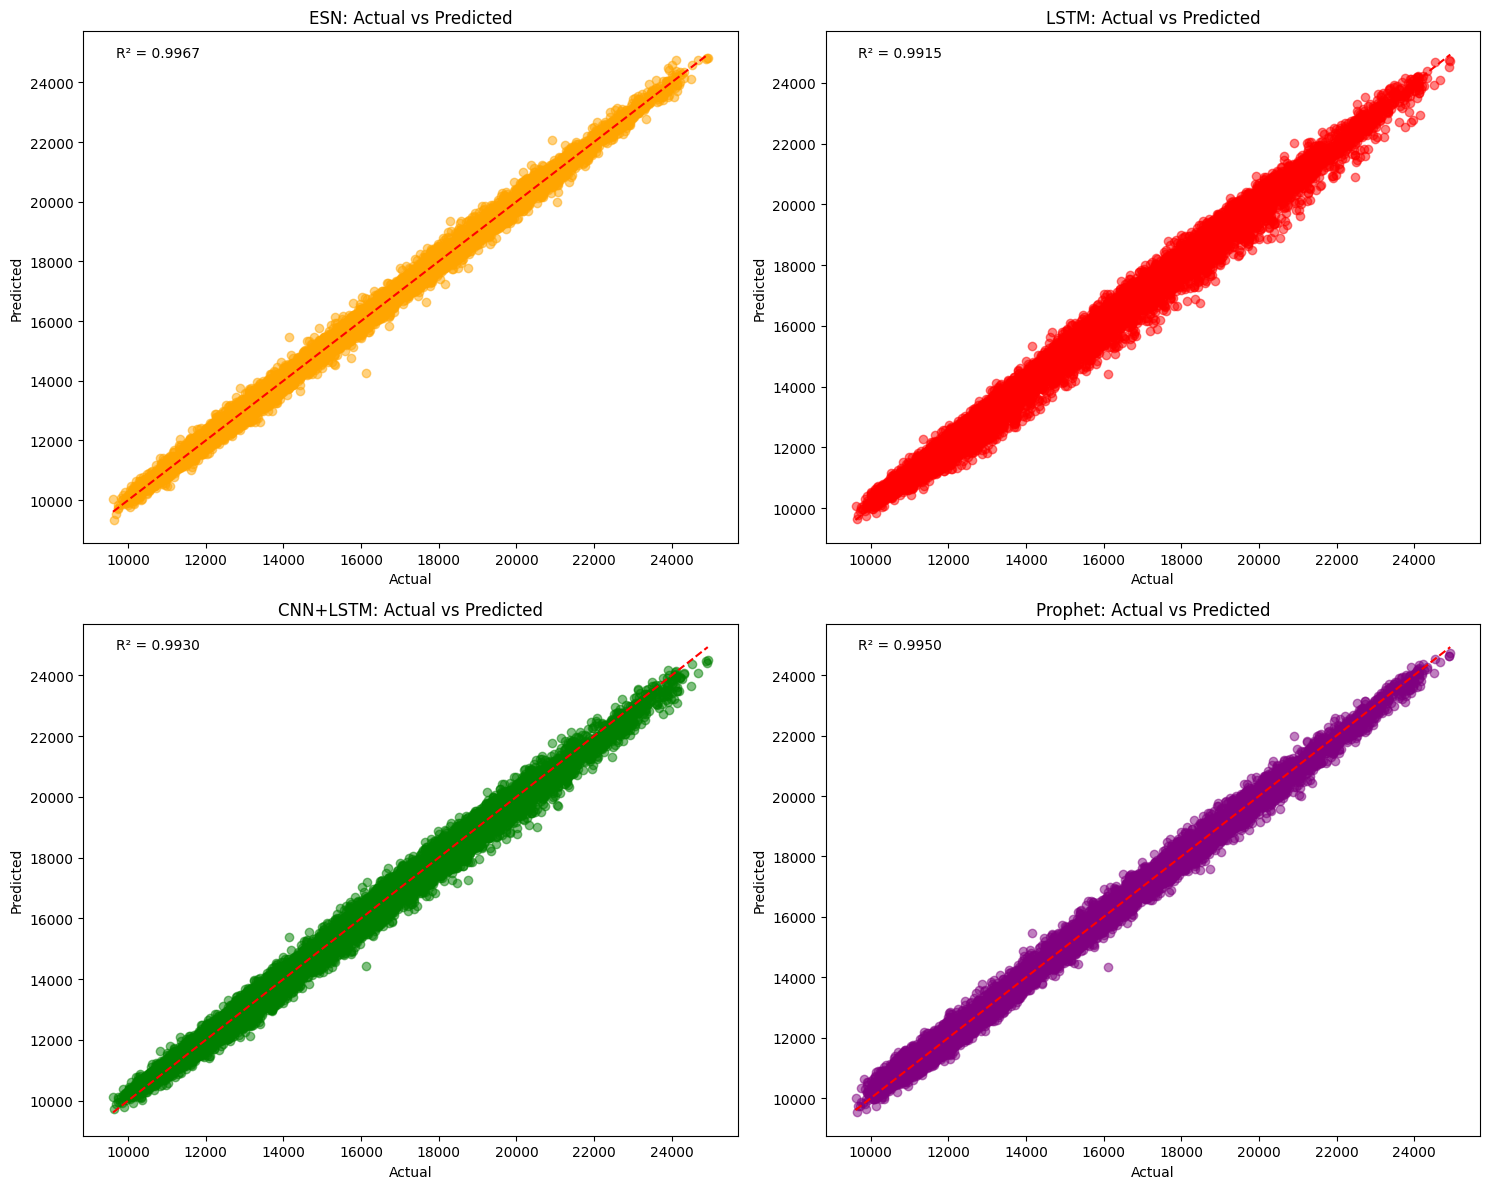

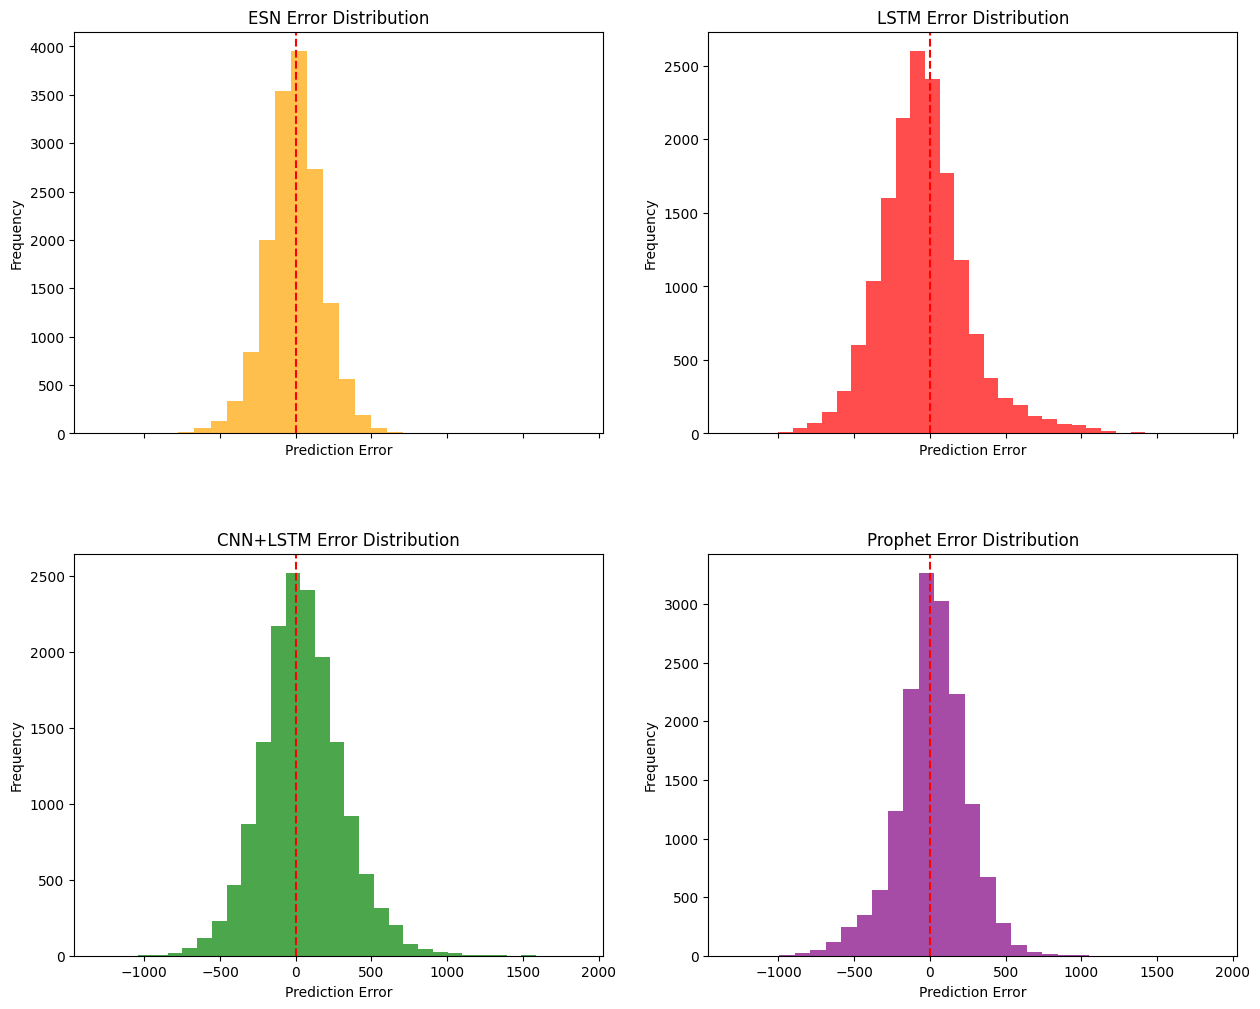

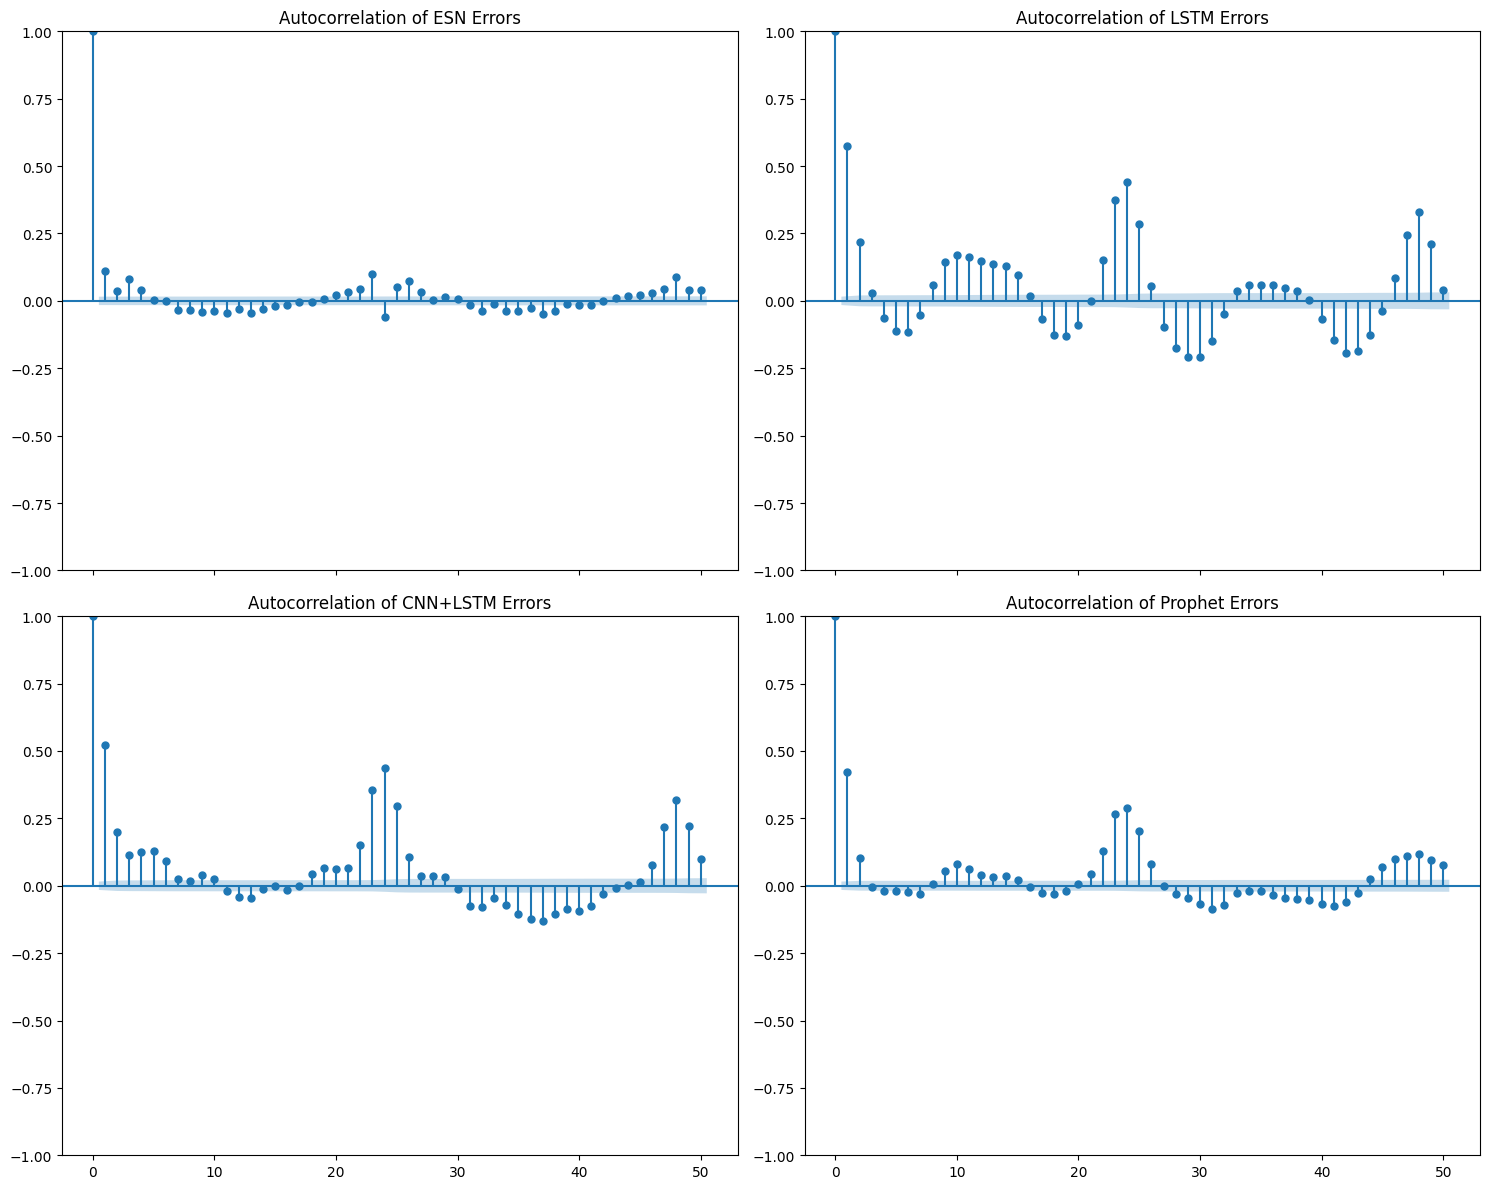

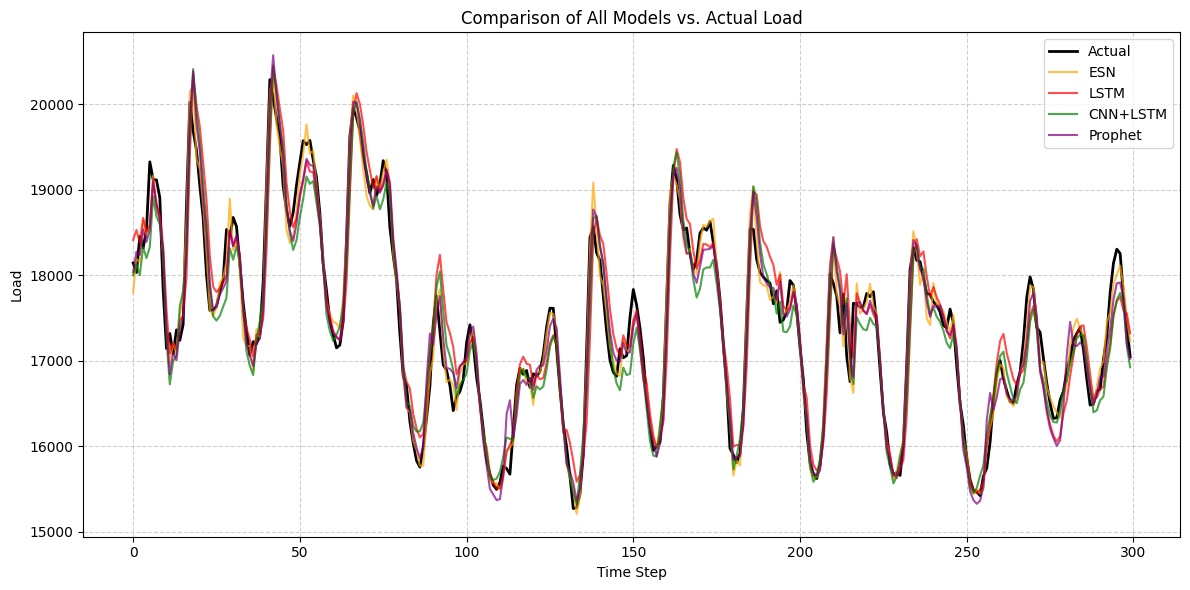

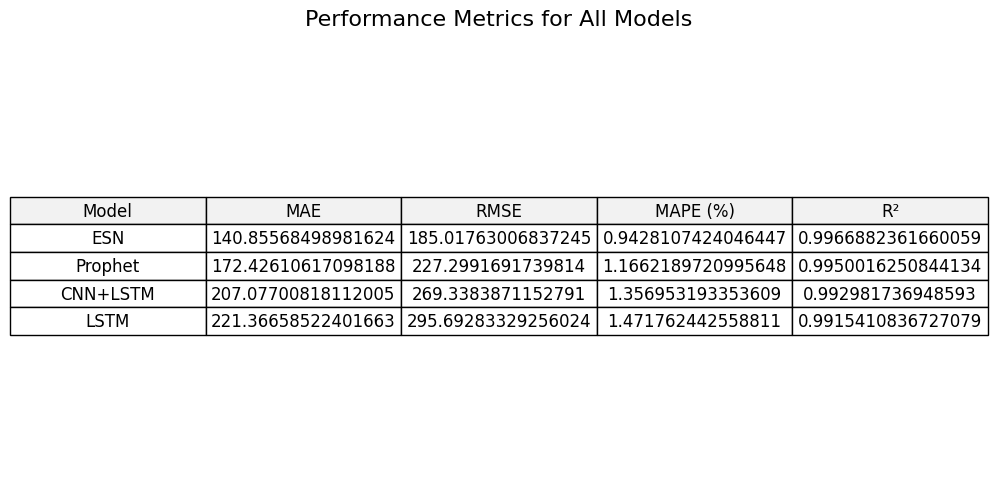

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate metrics for all models directly from predictions
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, mape, r2

# Calculate metrics for all models
models_data = {
    'ESN': y_pred_final,
    'LSTM': y_pred_lstm_final,
    'CNN+LSTM': y_pred_cnnlstm_final,
    'Prophet': y_pred_prophet_final
}
metrics = {name: calculate_metrics(y_test_final, pred) for name, pred in models_data.items()}
for name, (mae, rmse, mape, r2) in metrics.items():
    print(f"{name:<9}=> MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2f}%, R2={r2:.4f}")

max_plot = 300  # Number of test points to visualize

# 1. Comparison of predictions vs actual (subplots)
fig, axes = plt.subplots(4, 1, figsize=(12, 14), sharex=True)
colors = ['orange', 'red', 'green', 'purple']
for ax, (name, pred), color in zip(axes, models_data.items(), colors):
    ax.plot(y_test_final[:max_plot], label='Actual', linewidth=2, color='black')
    ax.plot(pred[:max_plot], label=name, alpha=0.7, color=color)
    ax.set_title(f'Actual vs. {name} Predictions')
    ax.set_ylabel('Load')
    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.6)
fig.suptitle('Comparison of Model Predictions with Actual Values', fontsize=16, y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.3)
plt.savefig('plots/model_predictions_comparison.png', dpi=300)
plt.savefig('plots/prophet_regressors.png', dpi=300)
plt.show()

# 2. Error Plots (subplots)
fig, axes = plt.subplots(4, 1, figsize=(12, 14), sharex=True)
for ax, (name, pred), color in zip(axes, models_data.items(), colors):
    error = y_test_final[:max_plot] - pred[:max_plot]
    ax.plot(error, color=color)
    ax.axhline(y=0, color='black', linestyle='--')
    ax.set_title(f'{name} Prediction Error')
    ax.set_ylabel('Error')
    ax.grid(True, linestyle='--', alpha=0.6)
axes[-1].set_xlabel('Time Step')
fig.suptitle('Prediction Errors Across Different Models', fontsize=16, y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.3)
plt.savefig('plots/model_errors_comparison.png', dpi=300)
plt.show()

# 3. Boxplot of absolute errors
plt.figure(figsize=(10, 6))
error_data = [np.abs(y_test_final - pred).flatten() for pred in models_data.values()]
plt.boxplot(error_data, labels=models_data.keys())
plt.title('Absolute Error Distribution Across Models')
plt.ylabel('Absolute Error')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('plots/absolute_error_boxplot.png', dpi=300)
plt.show()

# 4. Scatter plots (Actual vs Predicted)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
for ax, (name, pred), color in zip(axes.flatten(), models_data.items(), colors):
    ax.scatter(y_test_final, pred, alpha=0.5, color=color)
    ax.plot([min(y_test_final), max(y_test_final)], [min(y_test_final), max(y_test_final)], 'r--')
    ax.set_title(f'{name}: Actual vs Predicted')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    r2 = r2_score(y_test_final, pred)
    ax.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax.transAxes,
            backgroundcolor='white', fontsize=10)
plt.tight_layout()
plt.savefig('plots/actual_vs_predicted_scatter.png', dpi=300)
plt.show()

# 5. Error distribution histograms
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True)
for ax, (name, pred), color in zip(axes.flatten(), models_data.items(), colors):
    ax.hist(y_test_final - pred, bins=30, alpha=0.7, color=color)
    ax.set_title(f'{name} Error Distribution')
    ax.axvline(x=0, color='r', linestyle='--')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Prediction Error')
plt.subplots_adjust(hspace=0.3)
plt.savefig('plots/error_distribution_histograms.png', dpi=300)
plt.show()

# 6. Autocorrelation of errors
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True)
for ax, (name, pred) in zip(axes.flatten(), models_data.items()):
    plot_acf(y_test_final - pred, ax=ax, lags=50)
    ax.set_title(f'Autocorrelation of {name} Errors')
plt.tight_layout()
plt.savefig('plots/error_autocorrelation.png', dpi=300)
plt.show()

# 7. Combined line plot of all models
plt.figure(figsize=(12, 6))
plt.plot(y_test_final[:max_plot], label='Actual', linewidth=2, color='black')
for name, pred, color in zip(models_data.keys(), models_data.values(), colors):
    plt.plot(pred[:max_plot], label=name, alpha=0.7, color=color)
plt.title('Comparison of All Models vs. Actual Load')
plt.xlabel('Time Step')
plt.ylabel('Load')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('plots/all_models_combined.png', dpi=300)
plt.show()

# 8. Table of metrics
metrics_df = pd.DataFrame({
    'Model': list(metrics.keys()),
    'MAE': [m[0] for m in metrics.values()],
    'RMSE': [m[1] for m in metrics.values()],
    'MAPE (%)': [m[2] for m in metrics.values()],
    'R²': [m[3] for m in metrics.values()]
}).sort_values('MAPE (%)')

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns,
                 cellLoc='center', loc='center', colColours=['#f2f2f2']*5)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
plt.title('Performance Metrics for All Models', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('plots/metrics_table.png', dpi=300, bbox_inches='tight')
plt.show()
